<a href="https://colab.research.google.com/github/kgpark88/ai-summary/blob/main/energy_usage_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

# 빌딩 에너지 사용량 예측 모델링
* 빌딩 에너지 효율화에 필수 기능인 에너지 사용량 예측 모델을 개발합니다.
* 시계열 데이터로 미래의 값을 예측하는 것은 판매량 예측, 주가 예측, 날씨예측 등 다양한 분야에 활용할 수 있습니다. 

## 필요 라이브러리(패키지)
- Numpy : 다차원 배열 연산
- Pandas : 데이타 처리와 분석
- Matplotlib : 데이터를 차트나 플롯(Plot)으로 시각화
- Scikit Learn : 교육 및 실무를 위한 머신러닝 패키지
- TensorFlow : 구글에서 만든 오픈소스 딥러닝 프레임워크

## 데이터 파일 : e_usage_train.csv, e_usage_test.csv
- 데이터 설명 : ABC 빌딩의 15분 전기에너지 사용량 데이터
- e_usage_train.csv : 모델 학습(Train) 데이터,        70,000개
- e_usage_test.csv : 모델 성능 테스트(Test) 데이터, 35,040개
- 빌딩의 전기에너지 검침 주기가 15분으로,   
  1시간에는 4개의 데이터, 
  하루에는 96개(4개x24시) 데이터,   
  1년 기간에는 35,040개(4개x24시x365일)의 데이터가 있습니다.

## 데이터 컬럼명
- daq_time : 데이터 수집 시간
- wday : 요일 구분
- day_type : 일 구분, 1 - 평일, 2 - 토요일, 3 - 일요일, 휴일
- temp : 온도( °C )
- rh : 상대습도(%)




## STEP 1. 라이브러리 import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## STEP 2. 시계열 데이터 처리

### csv 파일에서 Train 데이터를 로드합니다.

In [2]:
# df = pd.read_csv('e_usage_train.csv', header = 0, delimiter = ',')
df = pd.read_csv('https://raw.githubusercontent.com/kgpark88/energy-bigdata-analysis/main/e_usage_train.csv', header = 0, delimiter = ',')

### 데이터를 확인합니다.

In [3]:
df.head()

,b_name,daq_time,wday,day_type,hour,temp,rh,p_usage
0,ABC,2016-01-01 0:15,5,3,1,-2.5,99.0,229
1,ABC,2016-01-01 0:30,5,3,1,-2.5,99.0,231
2,ABC,2016-01-01 0:45,5,3,1,-2.5,99.0,231
3,ABC,2016-01-01 1:00,5,3,1,-3.1,100.0,226
4,ABC,2016-01-01 1:15,5,3,2,-3.1,100.0,229


In [4]:
df.tail()

,b_name,daq_time,wday,day_type,hour,temp,rh,p_usage
70171,ABC,2017-12-31 23:00,7,3,23,-1.6,42.0,278
70172,ABC,2017-12-31 23:15,7,3,24,-1.6,42.0,281
70173,ABC,2017-12-31 23:30,7,3,24,-1.6,42.0,292
70174,ABC,2017-12-31 23:45,7,3,24,-1.6,42.0,293
70175,ABC,2017-12-31 23:59,7,3,24,-1.6,42.0,283


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70176 entries, 0 to 70175
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   b_name    70176 non-null  object 
 1   daq_time  70176 non-null  object 
 2   wday      70176 non-null  int64  
 3   day_type  70176 non-null  int64  
 4   hour      70176 non-null  int64  
 5   temp      70176 non-null  float64
 6   rh        70176 non-null  float64
 7   p_usage   70176 non-null  int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 4.3+ MB


In [6]:
df.describe()

,wday,day_type,hour,temp,rh,p_usage
count,70176.000000,70176.000000,70176.000000,70176.000000,70176.000000,70176.000000
mean,4.008208,1.455540,12.500000,13.118254,67.584975,322.534328
std,2.000681,0.748287,6.922236,11.044776,22.356921,62.353697
min,1.000000,1.000000,1.000000,-16.200000,11.000000,0.000000
25%,2.000000,1.000000,6.750000,3.500000,50.000000,283.000000
50%,4.000000,1.000000,12.500000,14.300000,67.000000,312.000000
75%,6.000000,2.000000,18.250000,22.600000,88.000000,355.000000
max,7.000000,3.000000,24.000000,36.000000,100.000000,531.000000


### 시퀀스 데이터 구성
- 속성 데이터가 한개인 일변량 시계열(Univariate time series) 데이터, 
  또는 속성 데이터가 여러개인 다변량 시계열(Multivariate time series) 데이터를 입력으로 사용할 수 있습니다.
- 다양한 응용이 가능하도록 여러개의 속성을 입력데이터 사용 하겠습니다.
  
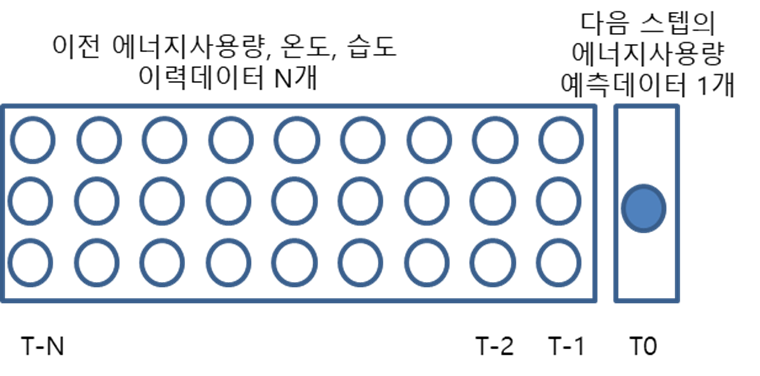

### 데이터셋을 입력시퀀스데이터와 타깃데이터로 분리하는 함수입니다.
- 시계열 데이터를 시퀀스 데이터로 변환
- 입력데이터는 시퀀스이고, 출력은 고정크기의 벡터나 스칼라인 다대일(many-to-one) 구조로 데이터 변환

In [7]:
def split_multivariate_data(dataset, target, start_index, end_index, hist_data_size, target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + hist_data_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-hist_data_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

### 입력시퀀스데이터, 타깃데이터, 예측데이터를 그래프에 출력하는 함수입니다.

In [8]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    n_steps = len(series)
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16, rotation=90)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)

### 전력사용량, 온도, 상대습도를 입력데이터(Feature)로 사용합니다.

In [9]:
features = ['p_usage', 'temp', 'rh']
features_data = df[features]
features_data.index = df['daq_time']
features_data.head()

,p_usage,temp,rh
daq_time,,,
2016-01-01 0:15,229,-2.5,99.0
2016-01-01 0:30,231,-2.5,99.0
2016-01-01 0:45,231,-2.5,99.0
2016-01-01 1:00,226,-3.1,100.0
2016-01-01 1:15,229,-3.1,100.0


### 시계열 데이터의 패턴을 확인합니다.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f74babac590>,
      dtype=object)

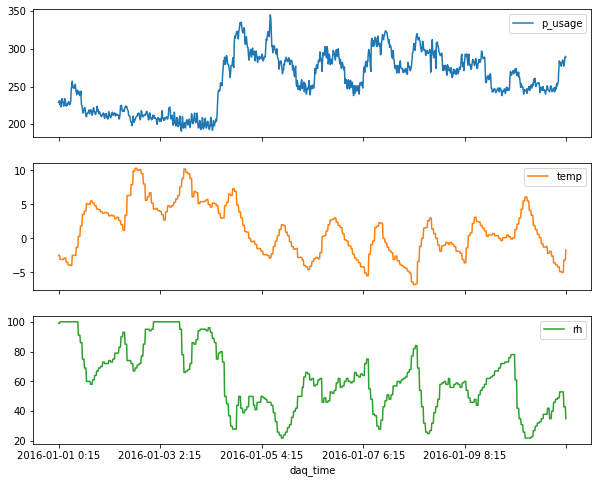

In [10]:
features_data[0:1000].plot(subplots=True, figsize=(10, 8))

In [11]:
dataset = features_data.values
dataset

array([[229. ,  -2.5,  99. ],
       [231. ,  -2.5,  99. ],
       [231. ,  -2.5,  99. ],
       ...,
       [292. ,  -1.6,  42. ],
       [293. ,  -1.6,  42. ],
       [283. ,  -1.6,  42. ]])

### 데이터셋의 피처(Feature)를 정규화(Scaling)합니다. 

In [12]:
TRAIN_SPLIT = 60000 
HISTORY_DATA_SIZE = 20
FUTURE_TARGET = 0
STEP = 1

In [13]:
scaler = MinMaxScaler()
dataset  = scaler.fit_transform(dataset)

In [14]:
dataset

array([[0.43126177, 0.26245211, 0.98876404],
       [0.43502825, 0.26245211, 0.98876404],
       [0.43502825, 0.26245211, 0.98876404],
       ...,
       [0.54990584, 0.27969349, 0.34831461],
       [0.55178908, 0.27969349, 0.34831461],
       [0.53295669, 0.27969349, 0.34831461]])

### Train 데이터셋과 Validation 데이터셋을 만듭니다.

In [15]:
X = dataset
y = dataset[:,0]

X_train, y_train = split_multivariate_data(X, y, 
                                           0, TRAIN_SPLIT, 
                                           HISTORY_DATA_SIZE, FUTURE_TARGET, 
                                           STEP, True)
X_valid, y_valid = split_multivariate_data(X, y, 
                                           TRAIN_SPLIT, None, 
                                           HISTORY_DATA_SIZE, FUTURE_TARGET, 
                                           STEP, True)

#### split_multivariate_data 함수가 반환하는 내용입니다.

In [16]:
print ('Single window of past history : {}'.format(X_train[0].shape))

Single window of past history : (20, 3)


In [17]:
print ('입력 데이터')
print (X_train[0])
print ('타겟 데이터')
print (y_train[0])

입력 데이터
[[0.43126177 0.26245211 0.98876404]
 [0.43502825 0.26245211 0.98876404]
 [0.43502825 0.26245211 0.98876404]
 [0.42561205 0.25095785 1.        ]
 [0.43126177 0.25095785 1.        ]
 [0.41996234 0.25095785 1.        ]
 [0.43879473 0.25095785 1.        ]
 [0.44067797 0.25095785 1.        ]
 [0.43314501 0.25095785 1.        ]
 [0.42937853 0.25095785 1.        ]
 [0.42184557 0.25095785 1.        ]
 [0.42561205 0.25478927 1.        ]
 [0.44067797 0.25478927 1.        ]
 [0.43502825 0.25478927 1.        ]
 [0.43126177 0.25478927 1.        ]
 [0.42184557 0.24329502 1.        ]
 [0.42561205 0.24329502 1.        ]
 [0.42372881 0.24329502 1.        ]
 [0.42937853 0.24329502 1.        ]
 [0.42937853 0.23563218 1.        ]]
타겟 데이터
0.4331450094161958


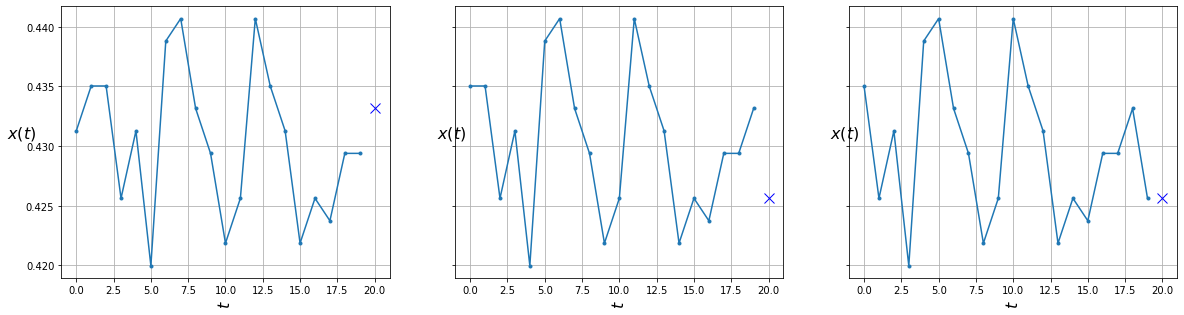

In [18]:
cols = 3
fig, axes = plt.subplots(nrows=1, ncols=cols, sharey=True, figsize=(20, 5))
for i in range(cols):
    plt.sca(axes[i])
    plot_series(X_train[i, :, 0], y_train[i])
plt.show()

## STEP 3. 딥러닝 모델 구현

데이터가 순차데이터(Sequence Data)인 시계열(Time Series) 이므로  
다양한 길이의 순차데이터 처리에 적합한 RNN 기반의 LSTM 모델을 사용합니다.  

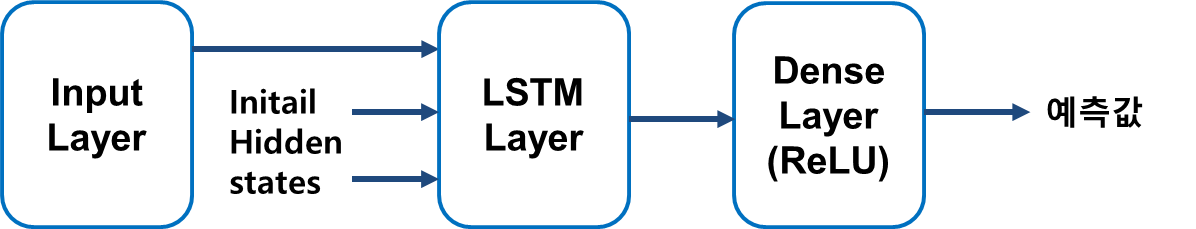
  
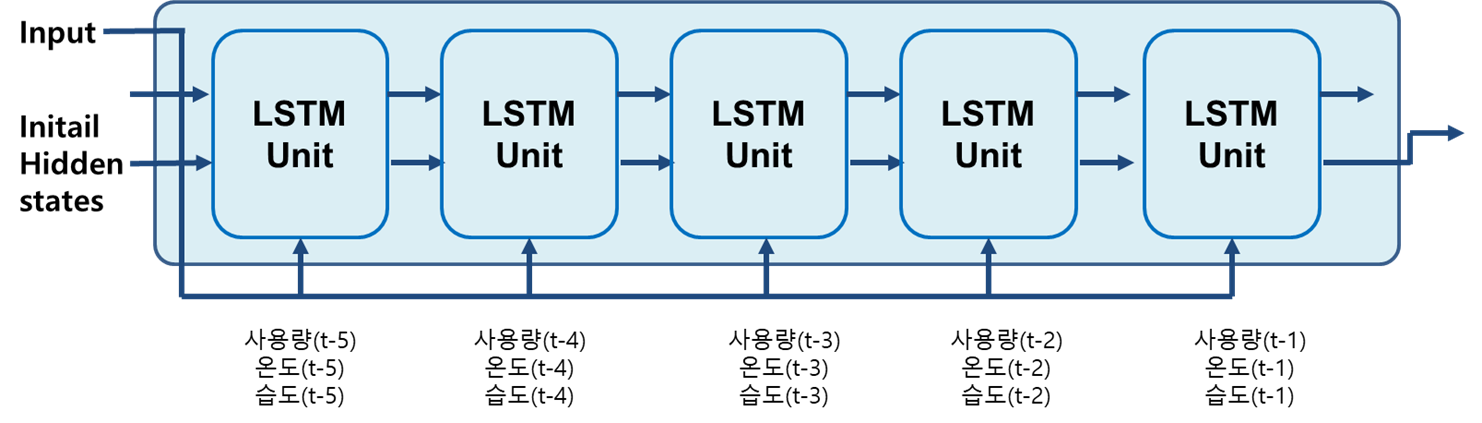

In [19]:
HIDDEN_SIZE = 10
DROP_OUT = 0.3

model = Sequential()
model.add(LSTM(HIDDEN_SIZE, input_shape=[20, 3], return_sequences=False))
model.add(Dropout(DROP_OUT))
model.add(Dense(1))

### 모델 구성 확인

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10)                560       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 571
Trainable params: 571
Non-trainable params: 0
_________________________________________________________________


### 초기 가중치 확인

In [21]:
hidden1 = model.layers[0]
hidden1.get_weights()

[array([[ 1.24903440e-01,  3.12458575e-01, -7.66246021e-02,
          7.71813989e-02,  2.77783573e-02, -3.33538204e-01,
         -2.98499763e-02, -3.30558985e-01,  4.93049920e-02,
         -3.32811922e-01, -3.26181442e-01, -5.63772321e-02,
          1.63959861e-02, -9.92715359e-02,  7.51085281e-02,
          3.68690491e-03,  3.65448654e-01, -1.07048571e-01,
         -2.07572818e-01, -3.04674208e-02, -1.25449926e-01,
          4.23367023e-02,  3.63870203e-01, -2.62508512e-01,
          3.45256507e-01, -1.24261379e-02,  2.66260326e-01,
          1.80510759e-01, -5.72585762e-02, -1.25102237e-01,
          2.08035648e-01, -2.44935960e-01,  1.92507207e-01,
         -2.64071524e-01, -7.40131736e-03, -4.47471738e-02,
         -7.25448728e-02, -6.87939525e-02, -3.39718252e-01,
         -1.77062184e-01],
        [ 4.63478565e-02,  4.47929502e-02, -5.92019260e-02,
         -1.96012944e-01, -3.48359376e-01, -2.79571027e-01,
          3.07370305e-01, -5.92941940e-02,  3.34725320e-01,
          4.9

### 모델 컴파일

In [22]:
model.compile(optimizer='adam', loss='mse')

### 모델 학습(Train) 조기종료, 체크포인트 설정

In [23]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', 
                    verbose=1, patience=5)
check_point = ModelCheckpoint('best_model.h5', verbose=1,
            monitor='val_loss', mode='min', save_best_only=True)

### 모델 학습(Train)
전력사용량 데이터는 일(Day) 단위 패턴이 있으므로 BATCH_SIZE를 96(15분*24시간=96)으로 해보겠습니다.

In [24]:
EPOCHS = 50
BATCH_SIZE=96

history = model.fit(x=X_train, y=y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE,
          verbose=1,                                     
          validation_data=(X_valid, y_valid), 
          callbacks=[early_stop, check_point])

Epoch 1/50
617/625 [============================>.] - ETA: 0s - loss: 0.0555
Epoch 1: val_loss improved from inf to 0.00183, saving model to best_model.h5
625/625 [==============================] - 9s 5ms/step - loss: 0.0550 - val_loss: 0.0018
Epoch 2/50
622/625 [============================>.] - ETA: 0s - loss: 0.0122
Epoch 2: val_loss improved from 0.00183 to 0.00087, saving model to best_model.h5
625/625 [==============================] - 3s 4ms/step - loss: 0.0121 - val_loss: 8.7406e-04
Epoch 3/50
624/625 [============================>.] - ETA: 0s - loss: 0.0075
Epoch 3: val_loss did not improve from 0.00087
625/625 [==============================] - 3s 4ms/step - loss: 0.0075 - val_loss: 9.6436e-04
Epoch 4/50
621/625 [============================>.] - ETA: 0s - loss: 0.0045
Epoch 4: val_loss improved from 0.00087 to 0.00075, saving model to best_model.h5
625/625 [==============================] - 3s 4ms/step - loss: 0.0045 - val_loss: 7.4955e-04
Epoch 5/50
620/625 [===============

### 모델의 Training Loss와 Validation Loss를 출력하는 함수입니다.

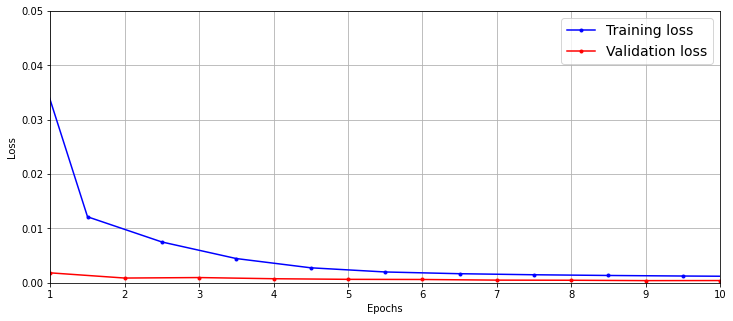

In [25]:
def plot_learning_curves(loss, val_loss):
    plt.figure(figsize=(12, 5))
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.axis([1, 10, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

### 모델 저장

In [26]:
model.save('my_model.h5')

## STEP 4. 딥러닝 모델 사용

### csv 파일에서 Test 데이터를 로드합니다.

In [30]:
# df = pd.read_csv('e_usage_test.csv', header = 0, delimiter = ',')
df = pd.read_csv('https://raw.githubusercontent.com/kgpark88/energy-bigdata-analysis/main/e_usage_test.csv', header = 0, delimiter = ',')

### 데이터를 확인합니다.

In [31]:
df.head()

,b_name,daq_time,wday,day_type,hour,temp,rh,p_usage
0,ABC,2018-01-01 0:15,1,3,1,-1.8,43,283
1,ABC,2018-01-01 0:30,1,3,1,-1.8,43,279
2,ABC,2018-01-01 0:45,1,3,1,-1.8,43,283
3,ABC,2018-01-01 1:00,1,3,1,-2.6,46,284
4,ABC,2018-01-01 1:15,1,3,2,-2.6,46,273


In [32]:
df.tail()

,b_name,daq_time,wday,day_type,hour,temp,rh,p_usage
35035,ABC,2018-12-31 23:00,1,1,23,-2.6,62,230
35036,ABC,2018-12-31 23:15,1,1,24,-2.6,62,252
35037,ABC,2018-12-31 23:30,1,1,24,-2.6,62,253
35038,ABC,2018-12-31 23:45,1,1,24,-2.6,62,253
35039,ABC,2018-12-31 23:59,1,1,24,-2.6,62,264


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   b_name    35040 non-null  object 
 1   daq_time  35040 non-null  object 
 2   wday      35040 non-null  int64  
 3   day_type  35040 non-null  int64  
 4   hour      35040 non-null  int64  
 5   temp      35040 non-null  float64
 6   rh        35040 non-null  int64  
 7   p_usage   35040 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 2.1+ MB


### 전력사용량, 온도, 상대습도를 입력데이터(Feature)로 사용합니다.

In [34]:
features = ['p_usage', 'temp', 'rh']
features_data = df[features]
features_data.index = df['daq_time']
dataset = features_data.values
dataset

array([[283. ,  -1.8,  43. ],
       [279. ,  -1.8,  43. ],
       [283. ,  -1.8,  43. ],
       ...,
       [253. ,  -2.6,  62. ],
       [253. ,  -2.6,  62. ],
       [264. ,  -2.6,  62. ]])

### 데이터를 정규화(Scaling) 합니다.

In [35]:
scaled_dataset = scaler.transform(dataset)

In [36]:
X = scaled_dataset
y = scaled_dataset[:,0]

X_test, y_test = split_multivariate_data(X, y,
                                         0, None, 
                                         HISTORY_DATA_SIZE, FUTURE_TARGET, 
                                         STEP, True)

### 저장한 모델을 로드합니다.

In [37]:
model = load_model('best_model.h5')
# model = load_model('my_model.h5')

### 테스트 데이터셋으로 모델 성능을 평가합니다.

In [38]:
model.evaluate(X_test, y_test)

1095/1095 [==============================] - 3s 2ms/step - loss: 5.6620e-04


0.0005661952891387045

### 모델로 에너지 사용량을 예측합니다.

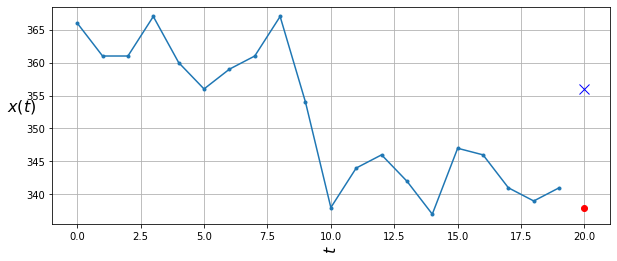

입력데이터 : [366. 361. 361. 367. 360. 356. 359. 361. 367. 354. 338. 344. 346. 342.
 337. 347. 346. 341. 339. 341.]
실제값 : 356.00
예측값 : 337.93
오차 : 18.07
오차율 : 5.07%


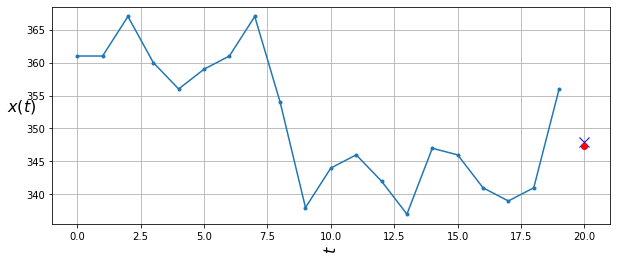

입력데이터 : [361. 361. 367. 360. 356. 359. 361. 367. 354. 338. 344. 346. 342. 337.
 347. 346. 341. 339. 341. 356.]
실제값 : 348.00
예측값 : 347.28
오차 : 0.72
오차율 : 0.21%


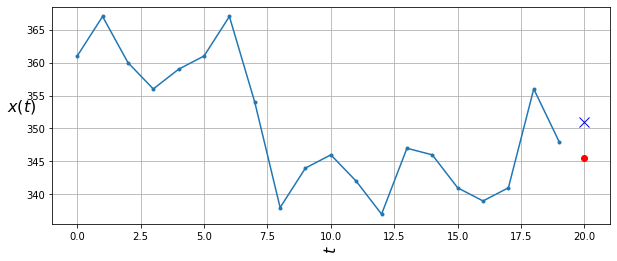

입력데이터 : [361. 367. 360. 356. 359. 361. 367. 354. 338. 344. 346. 342. 337. 347.
 346. 341. 339. 341. 356. 348.]
실제값 : 351.00
예측값 : 345.46
오차 : 5.54
오차율 : 1.58%


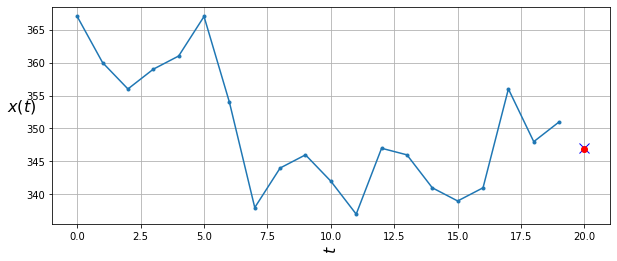

입력데이터 : [367. 360. 356. 359. 361. 367. 354. 338. 344. 346. 342. 337. 347. 346.
 341. 339. 341. 356. 348. 351.]
실제값 : 347.00
예측값 : 346.90
오차 : 0.10
오차율 : 0.03%


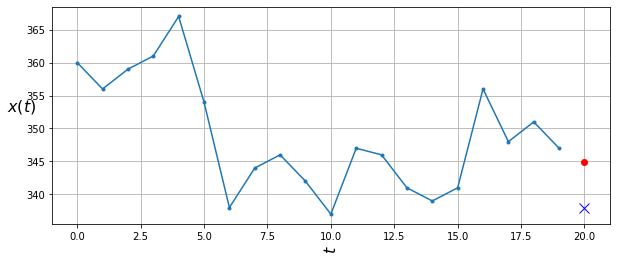

입력데이터 : [360. 356. 359. 361. 367. 354. 338. 344. 346. 342. 337. 347. 346. 341.
 339. 341. 356. 348. 351. 347.]
실제값 : 338.00
예측값 : 344.90
오차 : 6.90
오차율 : 2.04%


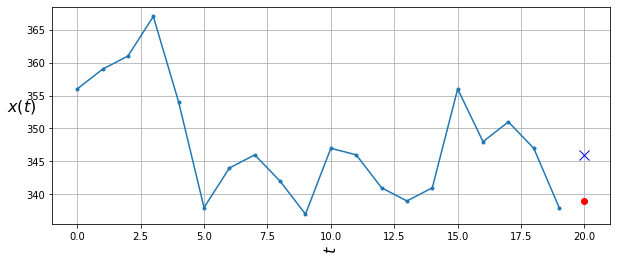

입력데이터 : [356. 359. 361. 367. 354. 338. 344. 346. 342. 337. 347. 346. 341. 339.
 341. 356. 348. 351. 347. 338.]
실제값 : 346.00
예측값 : 338.97
오차 : 7.03
오차율 : 2.03%


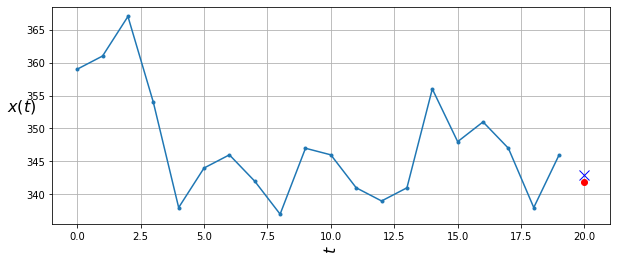

입력데이터 : [359. 361. 367. 354. 338. 344. 346. 342. 337. 347. 346. 341. 339. 341.
 356. 348. 351. 347. 338. 346.]
실제값 : 343.00
예측값 : 341.83
오차 : 1.17
오차율 : 0.34%


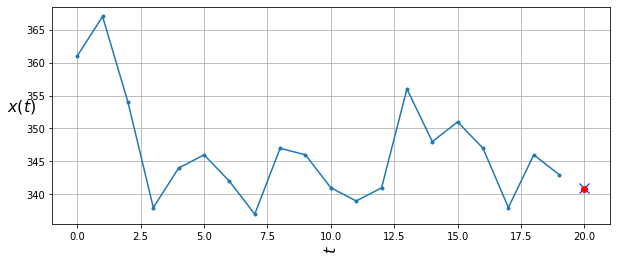

입력데이터 : [361. 367. 354. 338. 344. 346. 342. 337. 347. 346. 341. 339. 341. 356.
 348. 351. 347. 338. 346. 343.]
실제값 : 341.00
예측값 : 340.79
오차 : 0.21
오차율 : 0.06%


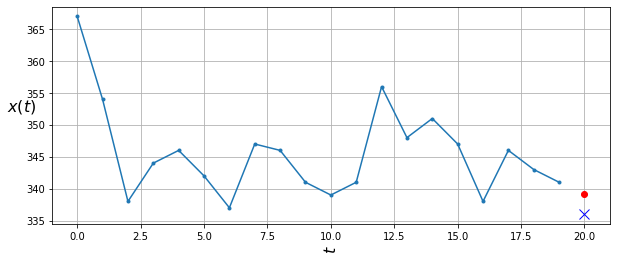

입력데이터 : [367. 354. 338. 344. 346. 342. 337. 347. 346. 341. 339. 341. 356. 348.
 351. 347. 338. 346. 343. 341.]
실제값 : 336.00
예측값 : 339.22
오차 : 3.22
오차율 : 0.96%


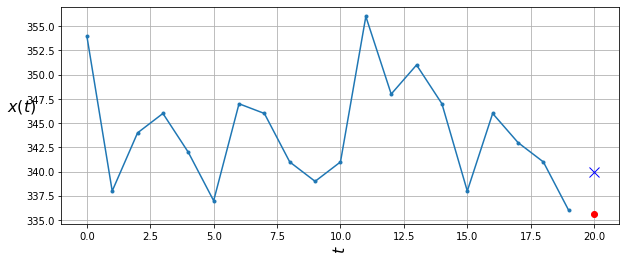

입력데이터 : [354. 338. 344. 346. 342. 337. 347. 346. 341. 339. 341. 356. 348. 351.
 347. 338. 346. 343. 341. 336.]
실제값 : 340.00
예측값 : 335.62
오차 : 4.38
오차율 : 1.29%


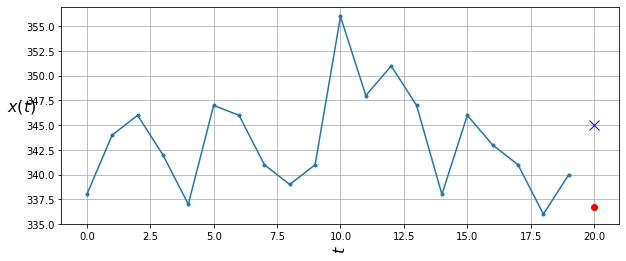

입력데이터 : [338. 344. 346. 342. 337. 347. 346. 341. 339. 341. 356. 348. 351. 347.
 338. 346. 343. 341. 336. 340.]
실제값 : 345.00
예측값 : 336.76
오차 : 8.24
오차율 : 2.39%


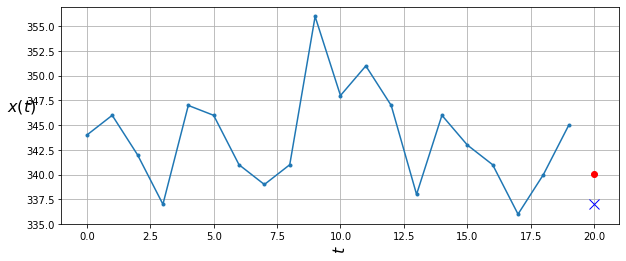

입력데이터 : [344. 346. 342. 337. 347. 346. 341. 339. 341. 356. 348. 351. 347. 338.
 346. 343. 341. 336. 340. 345.]
실제값 : 337.00
예측값 : 340.07
오차 : 3.07
오차율 : 0.91%


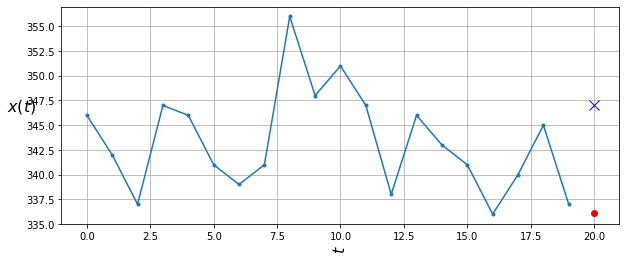

입력데이터 : [346. 342. 337. 347. 346. 341. 339. 341. 356. 348. 351. 347. 338. 346.
 343. 341. 336. 340. 345. 337.]
실제값 : 347.00
예측값 : 336.12
오차 : 10.88
오차율 : 3.13%


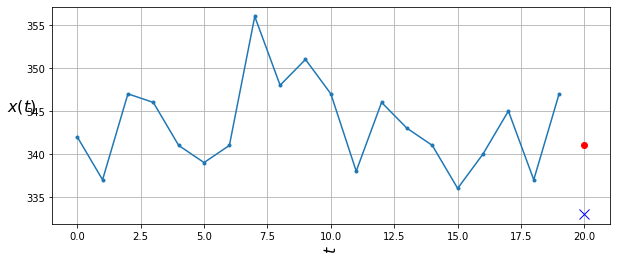

입력데이터 : [342. 337. 347. 346. 341. 339. 341. 356. 348. 351. 347. 338. 346. 343.
 341. 336. 340. 345. 337. 347.]
실제값 : 333.00
예측값 : 341.04
오차 : 8.04
오차율 : 2.41%


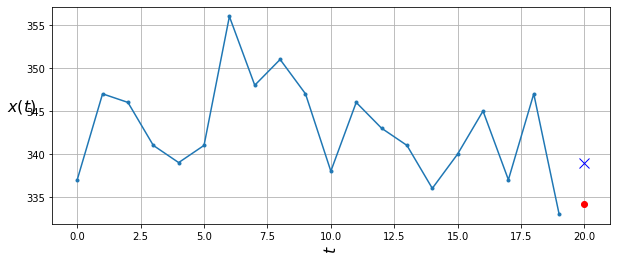

입력데이터 : [337. 347. 346. 341. 339. 341. 356. 348. 351. 347. 338. 346. 343. 341.
 336. 340. 345. 337. 347. 333.]
실제값 : 339.00
예측값 : 334.24
오차 : 4.76
오차율 : 1.40%


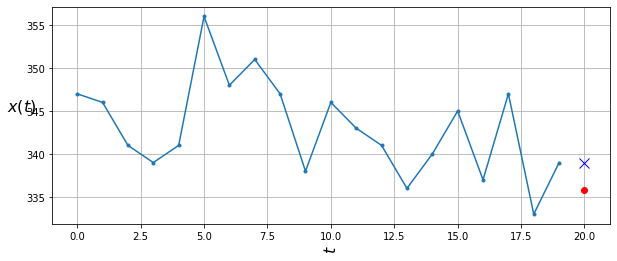

입력데이터 : [347. 346. 341. 339. 341. 356. 348. 351. 347. 338. 346. 343. 341. 336.
 340. 345. 337. 347. 333. 339.]
실제값 : 339.00
예측값 : 335.77
오차 : 3.23
오차율 : 0.95%


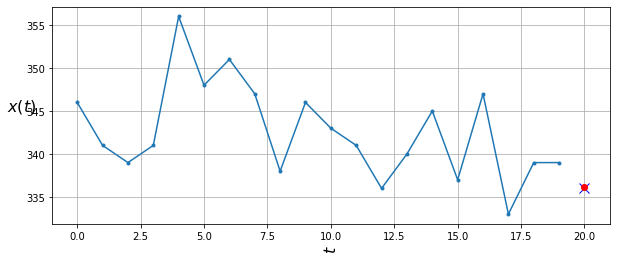

입력데이터 : [346. 341. 339. 341. 356. 348. 351. 347. 338. 346. 343. 341. 336. 340.
 345. 337. 347. 333. 339. 339.]
실제값 : 336.00
예측값 : 336.16
오차 : 0.16
오차율 : 0.05%


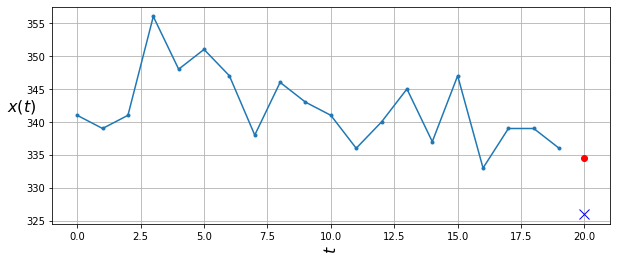

입력데이터 : [341. 339. 341. 356. 348. 351. 347. 338. 346. 343. 341. 336. 340. 345.
 337. 347. 333. 339. 339. 336.]
실제값 : 326.00
예측값 : 334.51
오차 : 8.51
오차율 : 2.61%


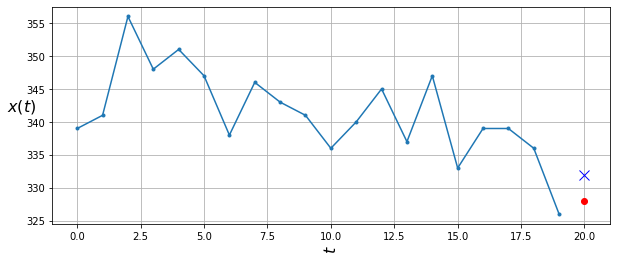

입력데이터 : [339. 341. 356. 348. 351. 347. 338. 346. 343. 341. 336. 340. 345. 337.
 347. 333. 339. 339. 336. 326.]
실제값 : 332.00
예측값 : 327.97
오차 : 4.03
오차율 : 1.21%


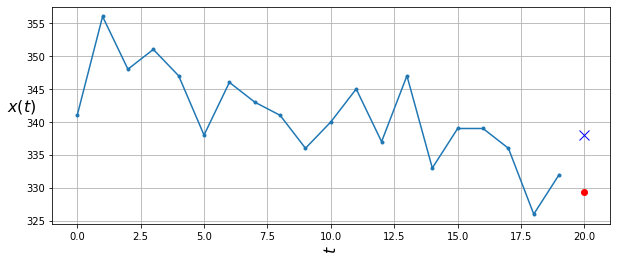

입력데이터 : [341. 356. 348. 351. 347. 338. 346. 343. 341. 336. 340. 345. 337. 347.
 333. 339. 339. 336. 326. 332.]
실제값 : 338.00
예측값 : 329.38
오차 : 8.62
오차율 : 2.55%


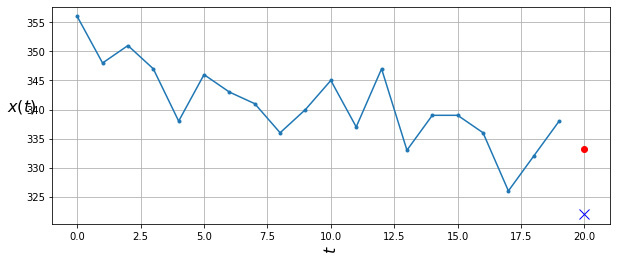

입력데이터 : [356. 348. 351. 347. 338. 346. 343. 341. 336. 340. 345. 337. 347. 333.
 339. 339. 336. 326. 332. 338.]
실제값 : 322.00
예측값 : 333.21
오차 : 11.21
오차율 : 3.48%


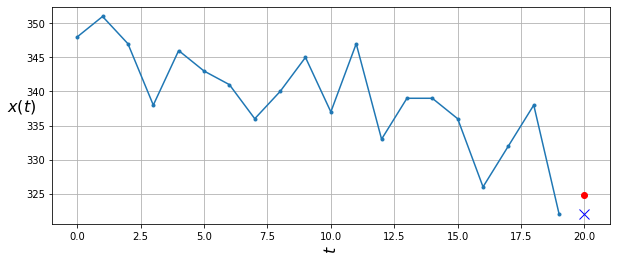

입력데이터 : [348. 351. 347. 338. 346. 343. 341. 336. 340. 345. 337. 347. 333. 339.
 339. 336. 326. 332. 338. 322.]
실제값 : 322.00
예측값 : 324.82
오차 : 2.82
오차율 : 0.88%


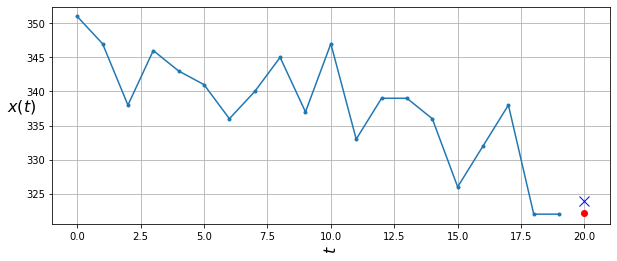

입력데이터 : [351. 347. 338. 346. 343. 341. 336. 340. 345. 337. 347. 333. 339. 339.
 336. 326. 332. 338. 322. 322.]
실제값 : 324.00
예측값 : 322.21
오차 : 1.79
오차율 : 0.55%


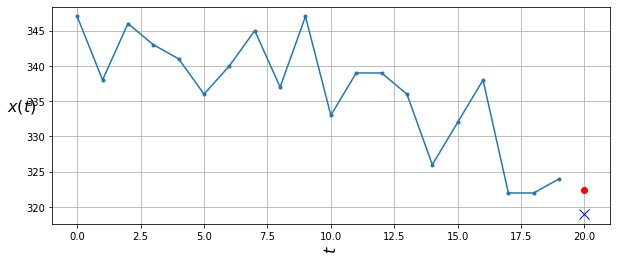

입력데이터 : [347. 338. 346. 343. 341. 336. 340. 345. 337. 347. 333. 339. 339. 336.
 326. 332. 338. 322. 322. 324.]
실제값 : 319.00
예측값 : 322.44
오차 : 3.44
오차율 : 1.08%


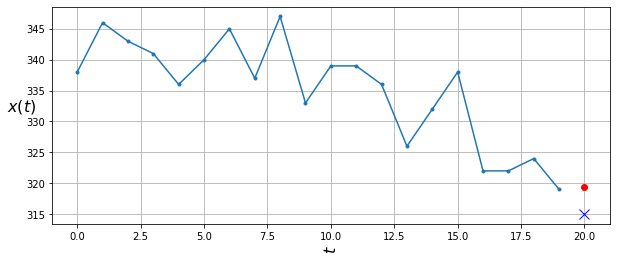

입력데이터 : [338. 346. 343. 341. 336. 340. 345. 337. 347. 333. 339. 339. 336. 326.
 332. 338. 322. 322. 324. 319.]
실제값 : 315.00
예측값 : 319.40
오차 : 4.40
오차율 : 1.40%


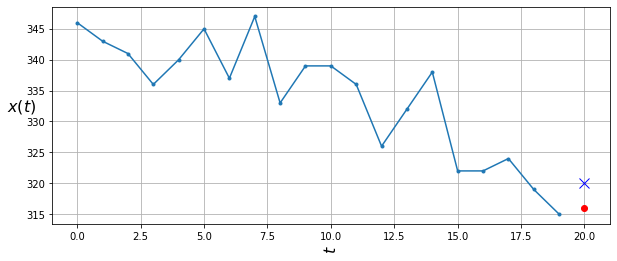

입력데이터 : [346. 343. 341. 336. 340. 345. 337. 347. 333. 339. 339. 336. 326. 332.
 338. 322. 322. 324. 319. 315.]
실제값 : 320.00
예측값 : 315.98
오차 : 4.02
오차율 : 1.26%


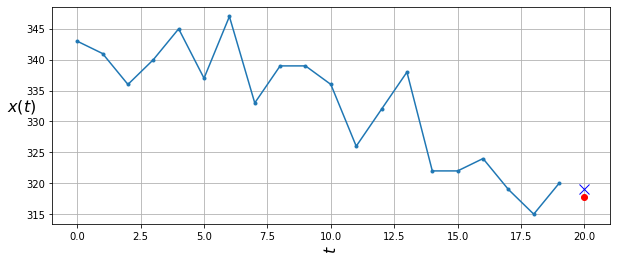

입력데이터 : [343. 341. 336. 340. 345. 337. 347. 333. 339. 339. 336. 326. 332. 338.
 322. 322. 324. 319. 315. 320.]
실제값 : 319.00
예측값 : 317.80
오차 : 1.20
오차율 : 0.38%


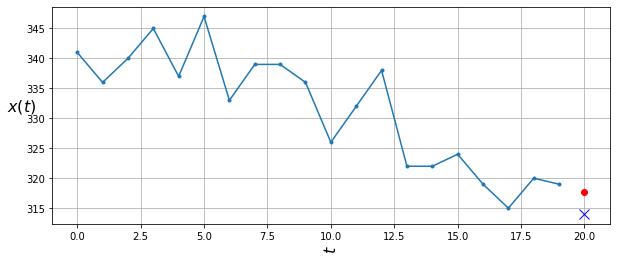

입력데이터 : [341. 336. 340. 345. 337. 347. 333. 339. 339. 336. 326. 332. 338. 322.
 322. 324. 319. 315. 320. 319.]
실제값 : 314.00
예측값 : 317.71
오차 : 3.71
오차율 : 1.18%


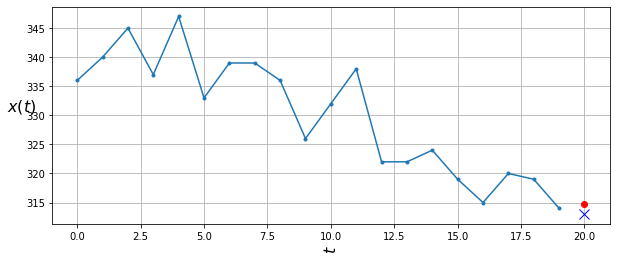

입력데이터 : [336. 340. 345. 337. 347. 333. 339. 339. 336. 326. 332. 338. 322. 322.
 324. 319. 315. 320. 319. 314.]
실제값 : 313.00
예측값 : 314.68
오차 : 1.68
오차율 : 0.54%


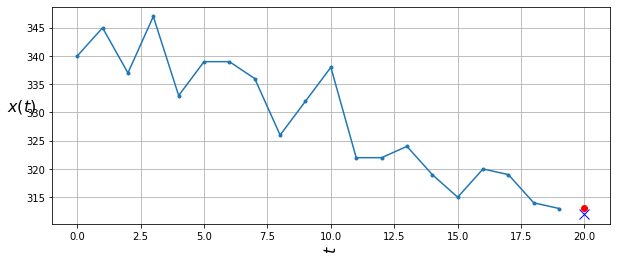

입력데이터 : [340. 345. 337. 347. 333. 339. 339. 336. 326. 332. 338. 322. 322. 324.
 319. 315. 320. 319. 314. 313.]
실제값 : 312.00
예측값 : 313.13
오차 : 1.13
오차율 : 0.36%


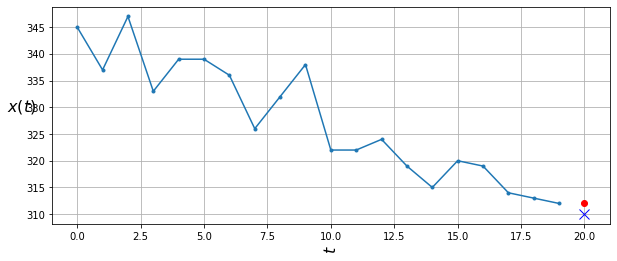

입력데이터 : [345. 337. 347. 333. 339. 339. 336. 326. 332. 338. 322. 322. 324. 319.
 315. 320. 319. 314. 313. 312.]
실제값 : 310.00
예측값 : 312.01
오차 : 2.01
오차율 : 0.65%


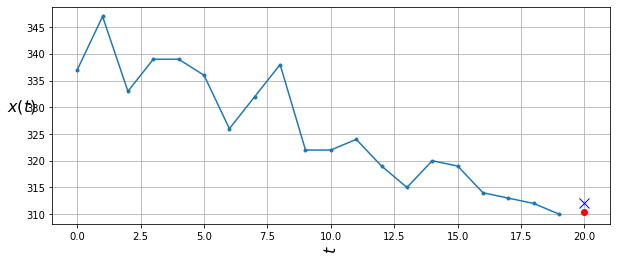

입력데이터 : [337. 347. 333. 339. 339. 336. 326. 332. 338. 322. 322. 324. 319. 315.
 320. 319. 314. 313. 312. 310.]
실제값 : 312.00
예측값 : 310.43
오차 : 1.57
오차율 : 0.50%


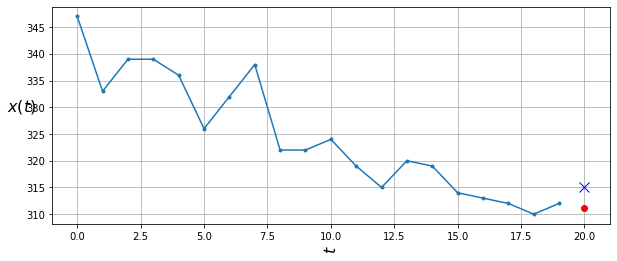

입력데이터 : [347. 333. 339. 339. 336. 326. 332. 338. 322. 322. 324. 319. 315. 320.
 319. 314. 313. 312. 310. 312.]
실제값 : 315.00
예측값 : 311.21
오차 : 3.79
오차율 : 1.20%


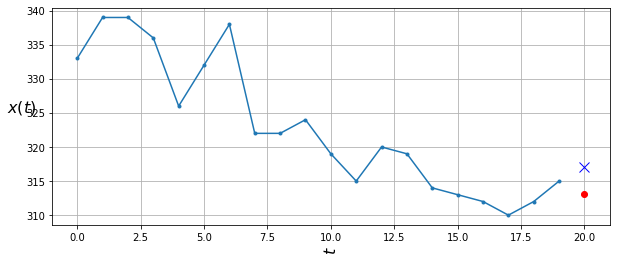

입력데이터 : [333. 339. 339. 336. 326. 332. 338. 322. 322. 324. 319. 315. 320. 319.
 314. 313. 312. 310. 312. 315.]
실제값 : 317.00
예측값 : 313.17
오차 : 3.83
오차율 : 1.21%


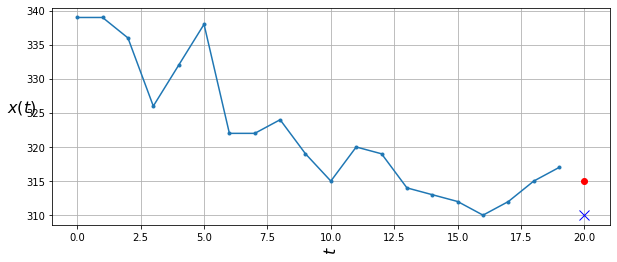

입력데이터 : [339. 339. 336. 326. 332. 338. 322. 322. 324. 319. 315. 320. 319. 314.
 313. 312. 310. 312. 315. 317.]
실제값 : 310.00
예측값 : 315.00
오차 : 5.00
오차율 : 1.61%


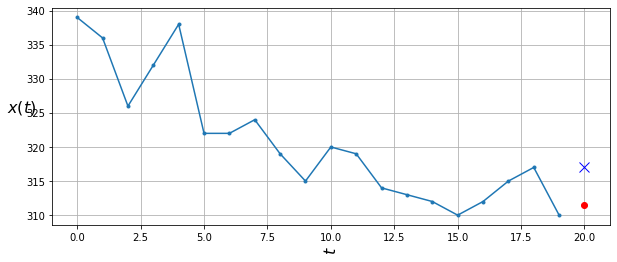

입력데이터 : [339. 336. 326. 332. 338. 322. 322. 324. 319. 315. 320. 319. 314. 313.
 312. 310. 312. 315. 317. 310.]
실제값 : 317.00
예측값 : 311.53
오차 : 5.47
오차율 : 1.72%


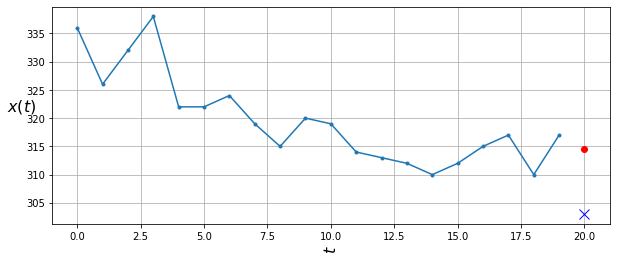

입력데이터 : [336. 326. 332. 338. 322. 322. 324. 319. 315. 320. 319. 314. 313. 312.
 310. 312. 315. 317. 310. 317.]
실제값 : 303.00
예측값 : 314.52
오차 : 11.52
오차율 : 3.80%


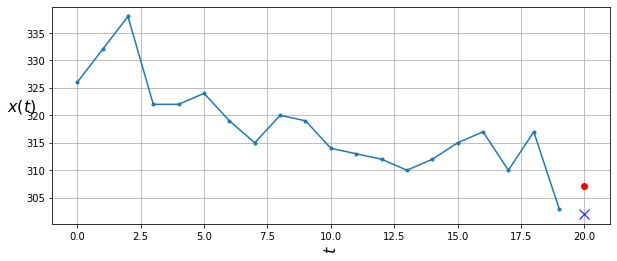

입력데이터 : [326. 332. 338. 322. 322. 324. 319. 315. 320. 319. 314. 313. 312. 310.
 312. 315. 317. 310. 317. 303.]
실제값 : 302.00
예측값 : 307.13
오차 : 5.13
오차율 : 1.70%


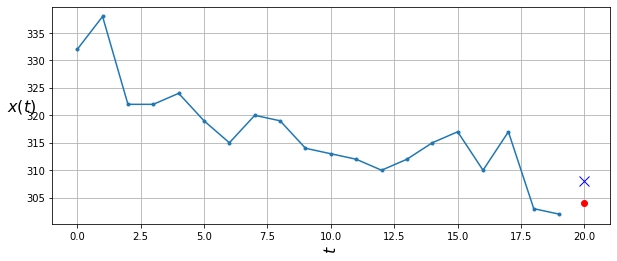

입력데이터 : [332. 338. 322. 322. 324. 319. 315. 320. 319. 314. 313. 312. 310. 312.
 315. 317. 310. 317. 303. 302.]
실제값 : 308.00
예측값 : 304.09
오차 : 3.91
오차율 : 1.27%


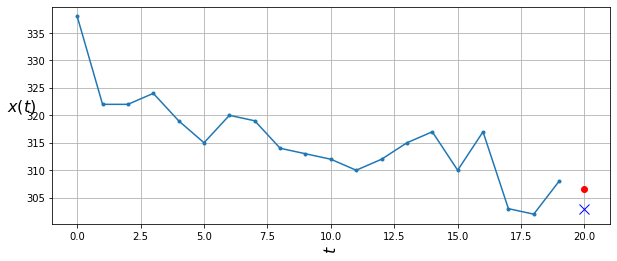

입력데이터 : [338. 322. 322. 324. 319. 315. 320. 319. 314. 313. 312. 310. 312. 315.
 317. 310. 317. 303. 302. 308.]
실제값 : 303.00
예측값 : 306.51
오차 : 3.51
오차율 : 1.16%


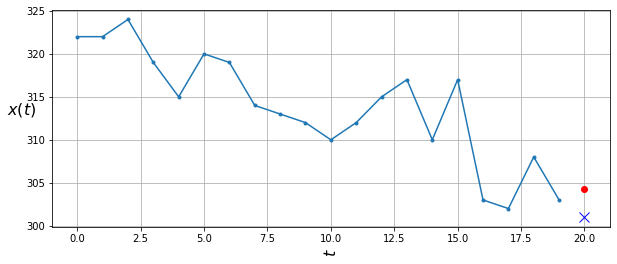

입력데이터 : [322. 322. 324. 319. 315. 320. 319. 314. 313. 312. 310. 312. 315. 317.
 310. 317. 303. 302. 308. 303.]
실제값 : 301.00
예측값 : 304.27
오차 : 3.27
오차율 : 1.09%


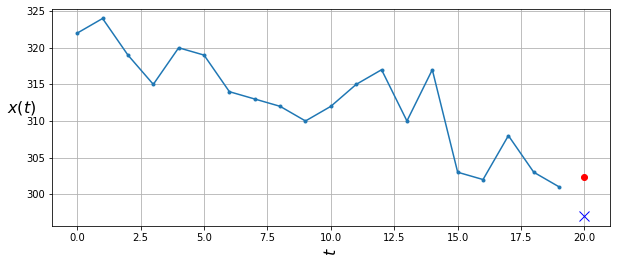

입력데이터 : [322. 324. 319. 315. 320. 319. 314. 313. 312. 310. 312. 315. 317. 310.
 317. 303. 302. 308. 303. 301.]
실제값 : 297.00
예측값 : 302.32
오차 : 5.32
오차율 : 1.79%


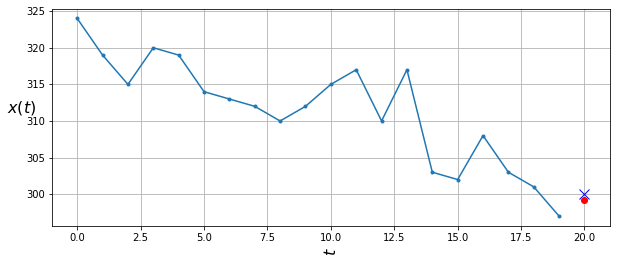

입력데이터 : [324. 319. 315. 320. 319. 314. 313. 312. 310. 312. 315. 317. 310. 317.
 303. 302. 308. 303. 301. 297.]
실제값 : 300.00
예측값 : 299.25
오차 : 0.75
오차율 : 0.25%


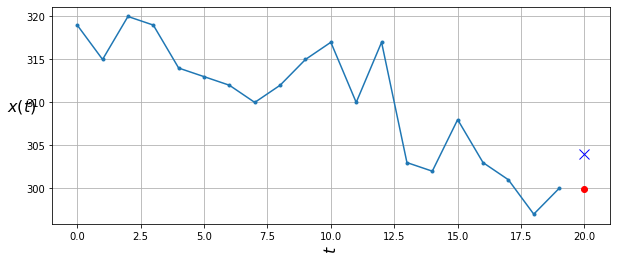

입력데이터 : [319. 315. 320. 319. 314. 313. 312. 310. 312. 315. 317. 310. 317. 303.
 302. 308. 303. 301. 297. 300.]
실제값 : 304.00
예측값 : 299.94
오차 : 4.06
오차율 : 1.33%


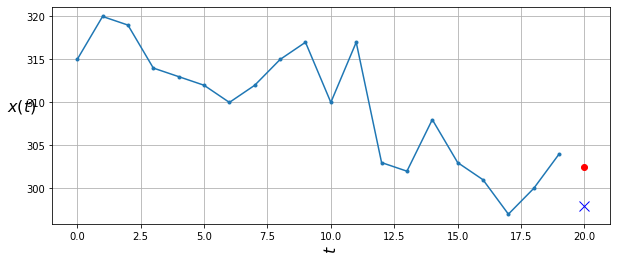

입력데이터 : [315. 320. 319. 314. 313. 312. 310. 312. 315. 317. 310. 317. 303. 302.
 308. 303. 301. 297. 300. 304.]
실제값 : 298.00
예측값 : 302.51
오차 : 4.51
오차율 : 1.51%


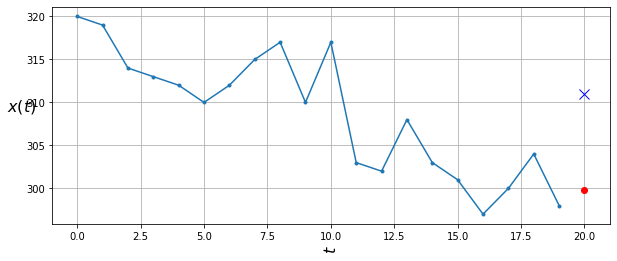

입력데이터 : [320. 319. 314. 313. 312. 310. 312. 315. 317. 310. 317. 303. 302. 308.
 303. 301. 297. 300. 304. 298.]
실제값 : 311.00
예측값 : 299.86
오차 : 11.14
오차율 : 3.58%


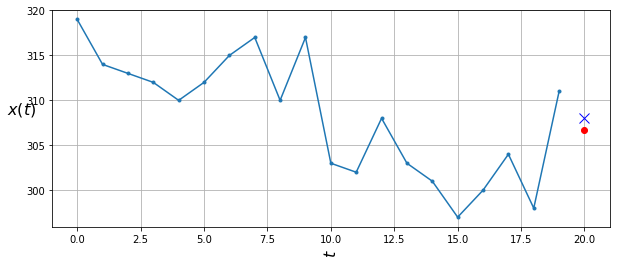

입력데이터 : [319. 314. 313. 312. 310. 312. 315. 317. 310. 317. 303. 302. 308. 303.
 301. 297. 300. 304. 298. 311.]
실제값 : 308.00
예측값 : 306.70
오차 : 1.30
오차율 : 0.42%


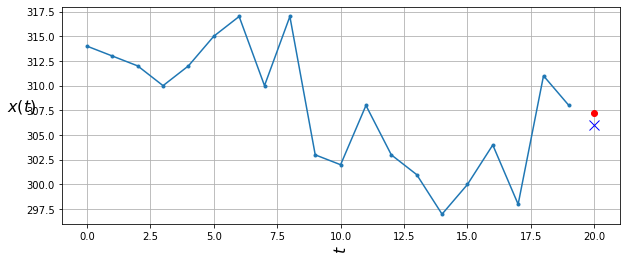

입력데이터 : [314. 313. 312. 310. 312. 315. 317. 310. 317. 303. 302. 308. 303. 301.
 297. 300. 304. 298. 311. 308.]
실제값 : 306.00
예측값 : 307.27
오차 : 1.27
오차율 : 0.42%


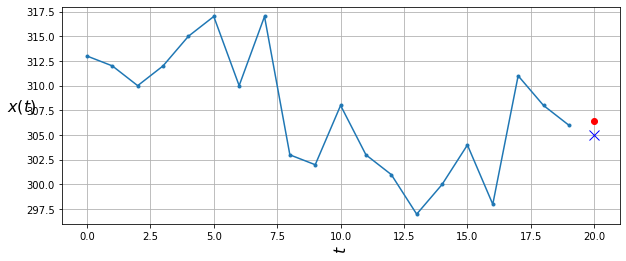

입력데이터 : [313. 312. 310. 312. 315. 317. 310. 317. 303. 302. 308. 303. 301. 297.
 300. 304. 298. 311. 308. 306.]
실제값 : 305.00
예측값 : 306.39
오차 : 1.39
오차율 : 0.46%


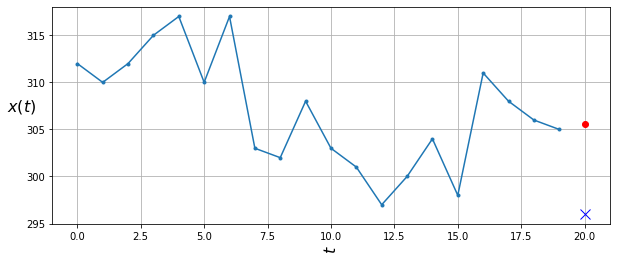

입력데이터 : [312. 310. 312. 315. 317. 310. 317. 303. 302. 308. 303. 301. 297. 300.
 304. 298. 311. 308. 306. 305.]
실제값 : 296.00
예측값 : 305.60
오차 : 9.60
오차율 : 3.24%


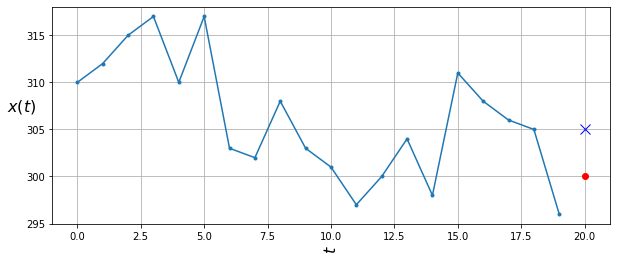

입력데이터 : [310. 312. 315. 317. 310. 317. 303. 302. 308. 303. 301. 297. 300. 304.
 298. 311. 308. 306. 305. 296.]
실제값 : 305.00
예측값 : 300.07
오차 : 4.93
오차율 : 1.62%


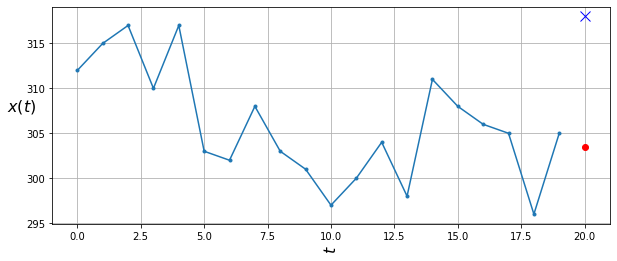

입력데이터 : [312. 315. 317. 310. 317. 303. 302. 308. 303. 301. 297. 300. 304. 298.
 311. 308. 306. 305. 296. 305.]
실제값 : 318.00
예측값 : 303.50
오차 : 14.50
오차율 : 4.56%


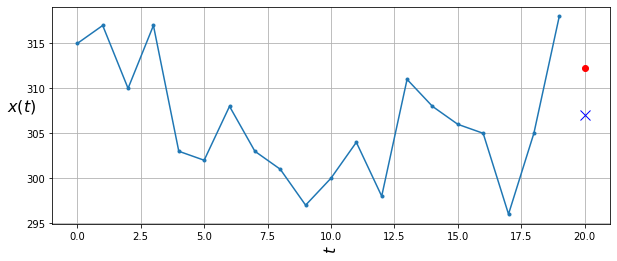

입력데이터 : [315. 317. 310. 317. 303. 302. 308. 303. 301. 297. 300. 304. 298. 311.
 308. 306. 305. 296. 305. 318.]
실제값 : 307.00
예측값 : 312.28
오차 : 5.28
오차율 : 1.72%


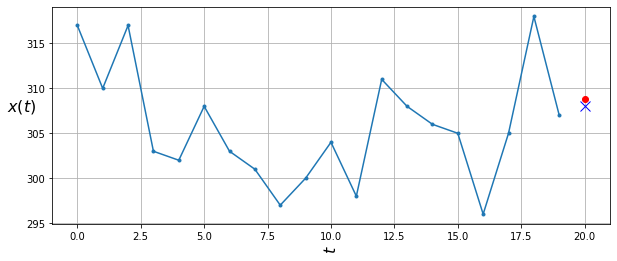

입력데이터 : [317. 310. 317. 303. 302. 308. 303. 301. 297. 300. 304. 298. 311. 308.
 306. 305. 296. 305. 318. 307.]
실제값 : 308.00
예측값 : 308.78
오차 : 0.78
오차율 : 0.25%


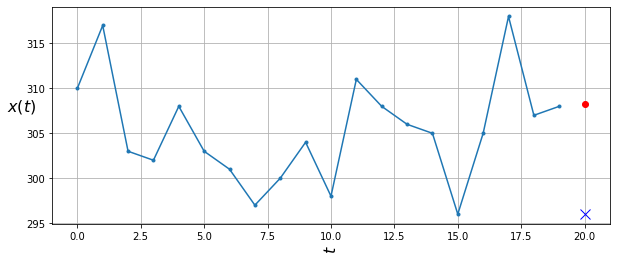

입력데이터 : [310. 317. 303. 302. 308. 303. 301. 297. 300. 304. 298. 311. 308. 306.
 305. 296. 305. 318. 307. 308.]
실제값 : 296.00
예측값 : 308.29
오차 : 12.29
오차율 : 4.15%


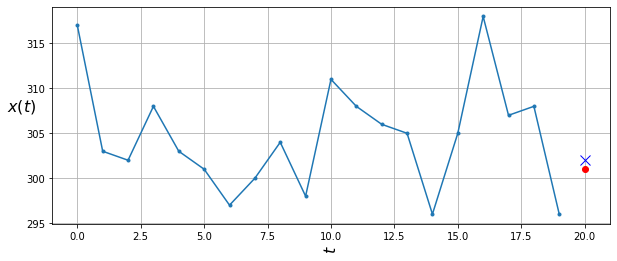

입력데이터 : [317. 303. 302. 308. 303. 301. 297. 300. 304. 298. 311. 308. 306. 305.
 296. 305. 318. 307. 308. 296.]
실제값 : 302.00
예측값 : 301.08
오차 : 0.92
오차율 : 0.30%


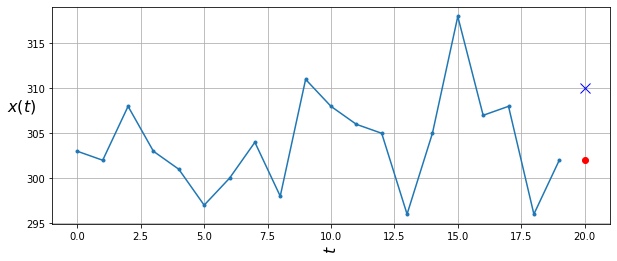

입력데이터 : [303. 302. 308. 303. 301. 297. 300. 304. 298. 311. 308. 306. 305. 296.
 305. 318. 307. 308. 296. 302.]
실제값 : 310.00
예측값 : 302.04
오차 : 7.96
오차율 : 2.57%


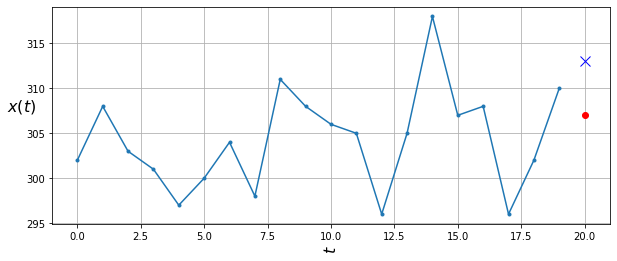

입력데이터 : [302. 308. 303. 301. 297. 300. 304. 298. 311. 308. 306. 305. 296. 305.
 318. 307. 308. 296. 302. 310.]
실제값 : 313.00
예측값 : 306.98
오차 : 6.02
오차율 : 1.92%


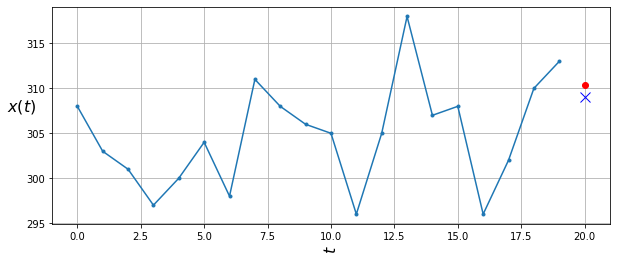

입력데이터 : [308. 303. 301. 297. 300. 304. 298. 311. 308. 306. 305. 296. 305. 318.
 307. 308. 296. 302. 310. 313.]
실제값 : 309.00
예측값 : 310.38
오차 : 1.38
오차율 : 0.45%


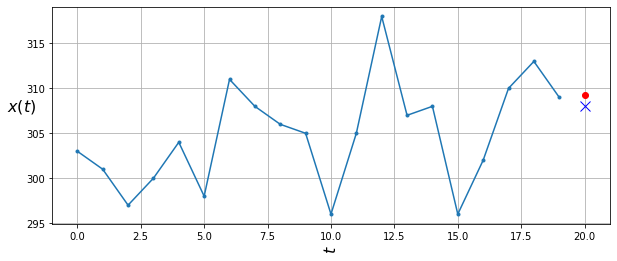

입력데이터 : [303. 301. 297. 300. 304. 298. 311. 308. 306. 305. 296. 305. 318. 307.
 308. 296. 302. 310. 313. 309.]
실제값 : 308.00
예측값 : 309.23
오차 : 1.23
오차율 : 0.40%


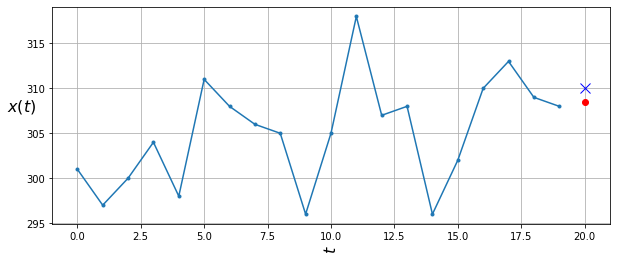

입력데이터 : [301. 297. 300. 304. 298. 311. 308. 306. 305. 296. 305. 318. 307. 308.
 296. 302. 310. 313. 309. 308.]
실제값 : 310.00
예측값 : 308.50
오차 : 1.50
오차율 : 0.48%


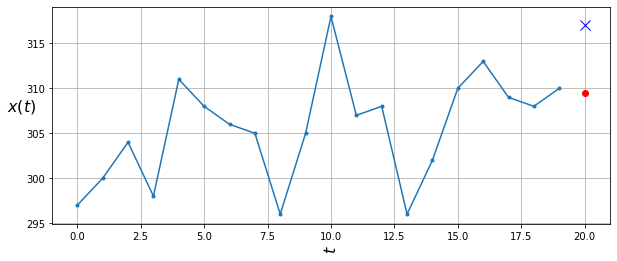

입력데이터 : [297. 300. 304. 298. 311. 308. 306. 305. 296. 305. 318. 307. 308. 296.
 302. 310. 313. 309. 308. 310.]
실제값 : 317.00
예측값 : 309.44
오차 : 7.56
오차율 : 2.38%


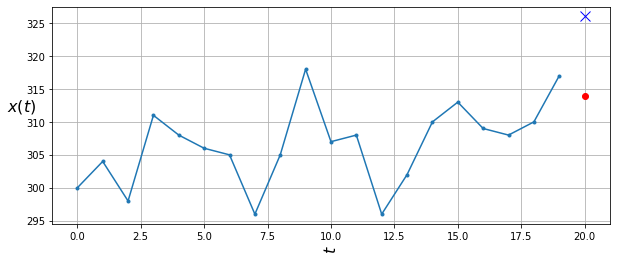

입력데이터 : [300. 304. 298. 311. 308. 306. 305. 296. 305. 318. 307. 308. 296. 302.
 310. 313. 309. 308. 310. 317.]
실제값 : 326.00
예측값 : 313.87
오차 : 12.13
오차율 : 3.72%


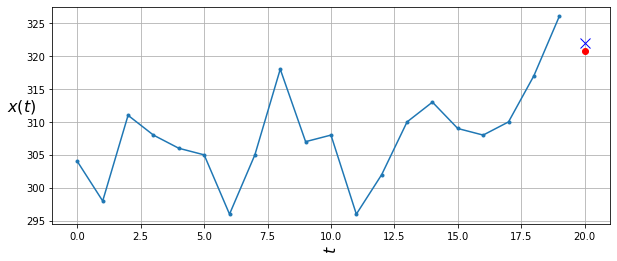

입력데이터 : [304. 298. 311. 308. 306. 305. 296. 305. 318. 307. 308. 296. 302. 310.
 313. 309. 308. 310. 317. 326.]
실제값 : 322.00
예측값 : 320.71
오차 : 1.29
오차율 : 0.40%


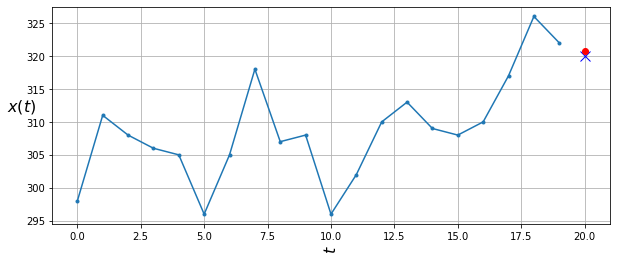

입력데이터 : [298. 311. 308. 306. 305. 296. 305. 318. 307. 308. 296. 302. 310. 313.
 309. 308. 310. 317. 326. 322.]
실제값 : 320.00
예측값 : 320.77
오차 : 0.77
오차율 : 0.24%


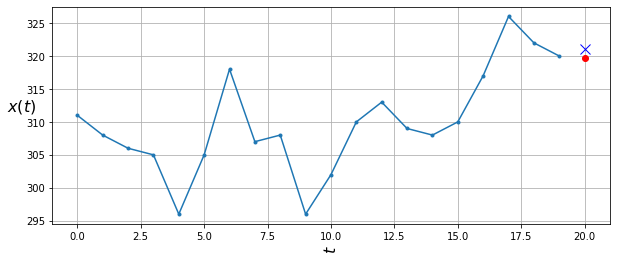

입력데이터 : [311. 308. 306. 305. 296. 305. 318. 307. 308. 296. 302. 310. 313. 309.
 308. 310. 317. 326. 322. 320.]
실제값 : 321.00
예측값 : 319.75
오차 : 1.25
오차율 : 0.39%


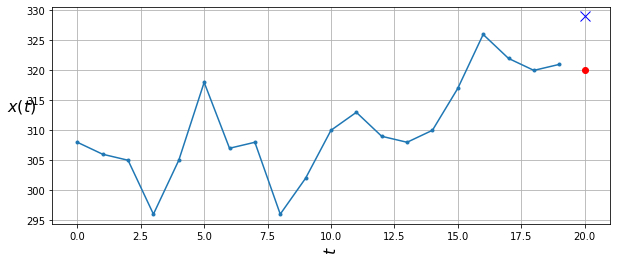

입력데이터 : [308. 306. 305. 296. 305. 318. 307. 308. 296. 302. 310. 313. 309. 308.
 310. 317. 326. 322. 320. 321.]
실제값 : 329.00
예측값 : 320.03
오차 : 8.97
오차율 : 2.73%


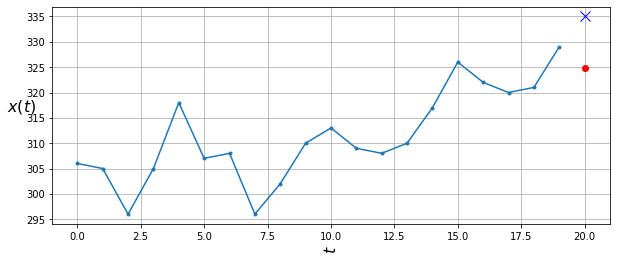

입력데이터 : [306. 305. 296. 305. 318. 307. 308. 296. 302. 310. 313. 309. 308. 310.
 317. 326. 322. 320. 321. 329.]
실제값 : 335.00
예측값 : 324.84
오차 : 10.16
오차율 : 3.03%


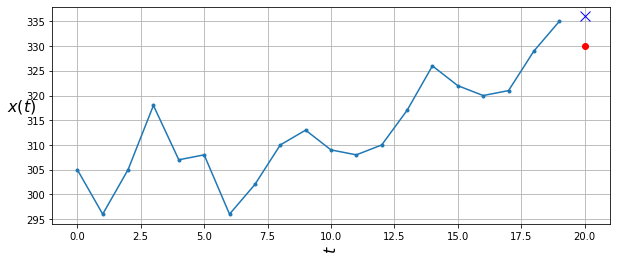

입력데이터 : [305. 296. 305. 318. 307. 308. 296. 302. 310. 313. 309. 308. 310. 317.
 326. 322. 320. 321. 329. 335.]
실제값 : 336.00
예측값 : 330.02
오차 : 5.98
오차율 : 1.78%


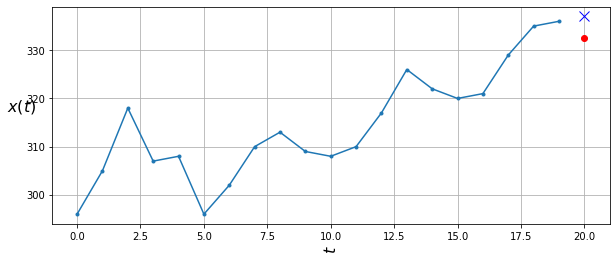

입력데이터 : [296. 305. 318. 307. 308. 296. 302. 310. 313. 309. 308. 310. 317. 326.
 322. 320. 321. 329. 335. 336.]
실제값 : 337.00
예측값 : 332.44
오차 : 4.56
오차율 : 1.35%


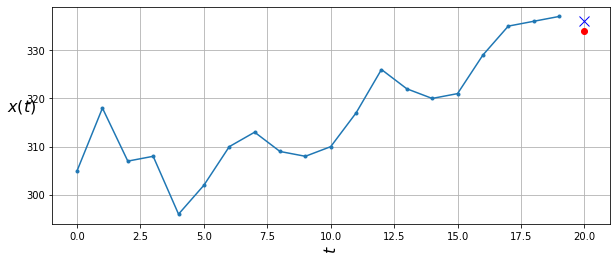

입력데이터 : [305. 318. 307. 308. 296. 302. 310. 313. 309. 308. 310. 317. 326. 322.
 320. 321. 329. 335. 336. 337.]
실제값 : 336.00
예측값 : 333.94
오차 : 2.06
오차율 : 0.61%


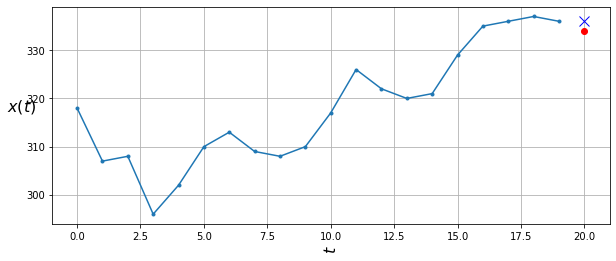

입력데이터 : [318. 307. 308. 296. 302. 310. 313. 309. 308. 310. 317. 326. 322. 320.
 321. 329. 335. 336. 337. 336.]
실제값 : 336.00
예측값 : 333.95
오차 : 2.05
오차율 : 0.61%


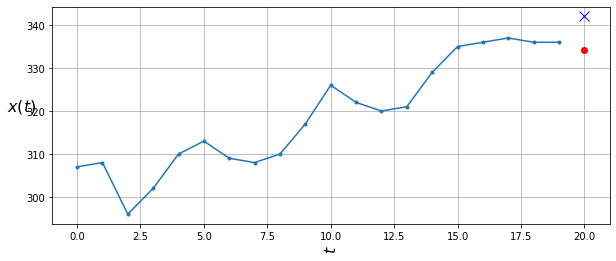

입력데이터 : [307. 308. 296. 302. 310. 313. 309. 308. 310. 317. 326. 322. 320. 321.
 329. 335. 336. 337. 336. 336.]
실제값 : 342.00
예측값 : 334.28
오차 : 7.72
오차율 : 2.26%


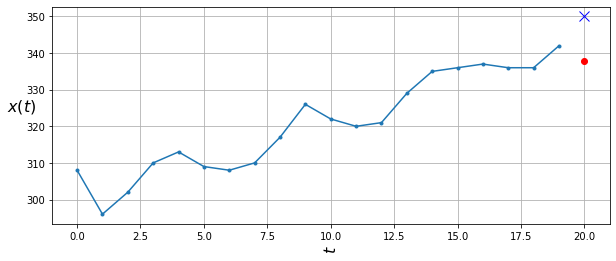

입력데이터 : [308. 296. 302. 310. 313. 309. 308. 310. 317. 326. 322. 320. 321. 329.
 335. 336. 337. 336. 336. 342.]
실제값 : 350.00
예측값 : 337.82
오차 : 12.18
오차율 : 3.48%


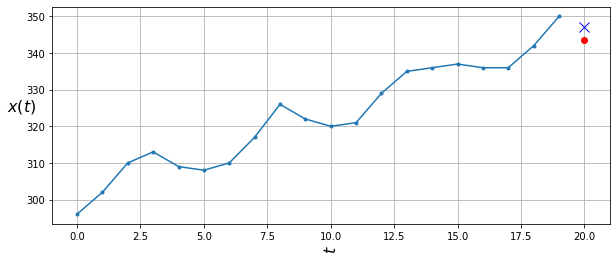

입력데이터 : [296. 302. 310. 313. 309. 308. 310. 317. 326. 322. 320. 321. 329. 335.
 336. 337. 336. 336. 342. 350.]
실제값 : 347.00
예측값 : 343.69
오차 : 3.31
오차율 : 0.95%


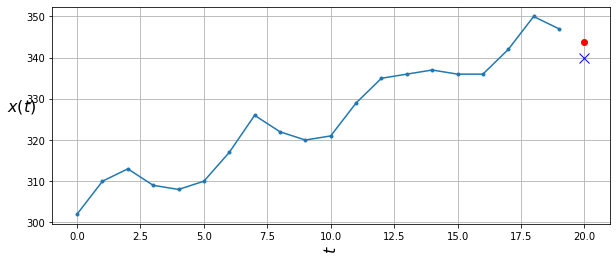

입력데이터 : [302. 310. 313. 309. 308. 310. 317. 326. 322. 320. 321. 329. 335. 336.
 337. 336. 336. 342. 350. 347.]
실제값 : 340.00
예측값 : 343.91
오차 : 3.91
오차율 : 1.15%


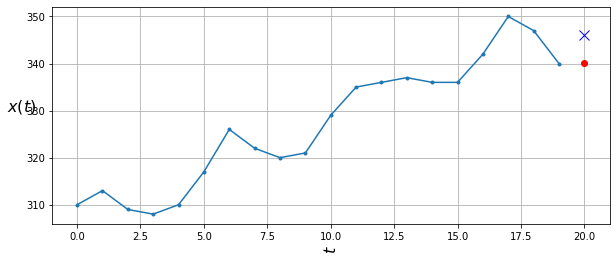

입력데이터 : [310. 313. 309. 308. 310. 317. 326. 322. 320. 321. 329. 335. 336. 337.
 336. 336. 342. 350. 347. 340.]
실제값 : 346.00
예측값 : 340.15
오차 : 5.85
오차율 : 1.69%


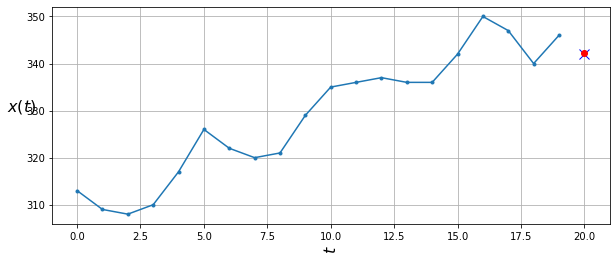

입력데이터 : [313. 309. 308. 310. 317. 326. 322. 320. 321. 329. 335. 336. 337. 336.
 336. 342. 350. 347. 340. 346.]
실제값 : 342.00
예측값 : 342.31
오차 : 0.31
오차율 : 0.09%


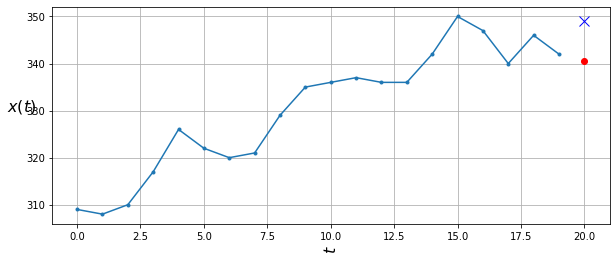

입력데이터 : [309. 308. 310. 317. 326. 322. 320. 321. 329. 335. 336. 337. 336. 336.
 342. 350. 347. 340. 346. 342.]
실제값 : 349.00
예측값 : 340.55
오차 : 8.45
오차율 : 2.42%


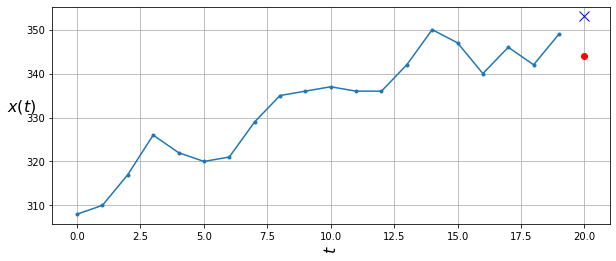

입력데이터 : [308. 310. 317. 326. 322. 320. 321. 329. 335. 336. 337. 336. 336. 342.
 350. 347. 340. 346. 342. 349.]
실제값 : 353.00
예측값 : 344.05
오차 : 8.95
오차율 : 2.53%


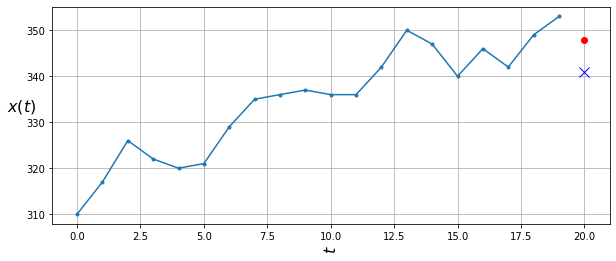

입력데이터 : [310. 317. 326. 322. 320. 321. 329. 335. 336. 337. 336. 336. 342. 350.
 347. 340. 346. 342. 349. 353.]
실제값 : 341.00
예측값 : 347.79
오차 : 6.79
오차율 : 1.99%


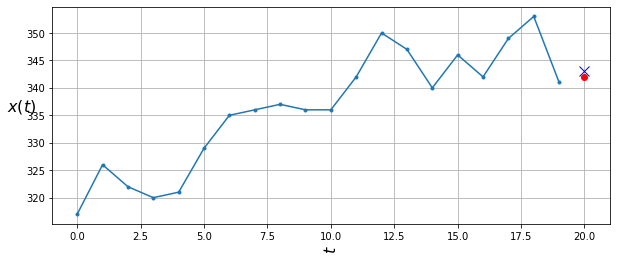

입력데이터 : [317. 326. 322. 320. 321. 329. 335. 336. 337. 336. 336. 342. 350. 347.
 340. 346. 342. 349. 353. 341.]
실제값 : 343.00
예측값 : 341.91
오차 : 1.09
오차율 : 0.32%


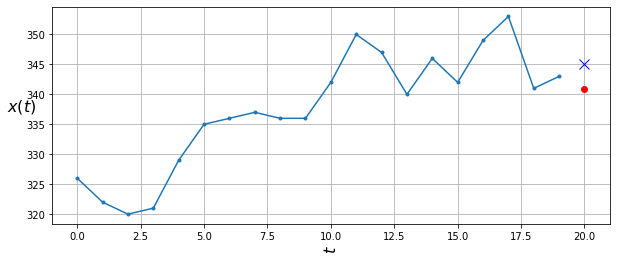

입력데이터 : [326. 322. 320. 321. 329. 335. 336. 337. 336. 336. 342. 350. 347. 340.
 346. 342. 349. 353. 341. 343.]
실제값 : 345.00
예측값 : 340.90
오차 : 4.10
오차율 : 1.19%


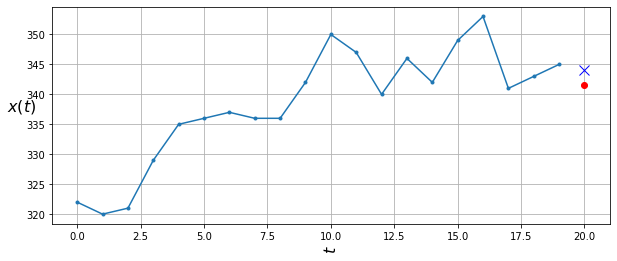

입력데이터 : [322. 320. 321. 329. 335. 336. 337. 336. 336. 342. 350. 347. 340. 346.
 342. 349. 353. 341. 343. 345.]
실제값 : 344.00
예측값 : 341.64
오차 : 2.36
오차율 : 0.69%


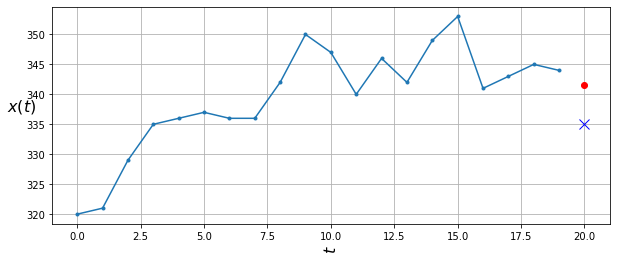

입력데이터 : [320. 321. 329. 335. 336. 337. 336. 336. 342. 350. 347. 340. 346. 342.
 349. 353. 341. 343. 345. 344.]
실제값 : 335.00
예측값 : 341.53
오차 : 6.53
오차율 : 1.95%


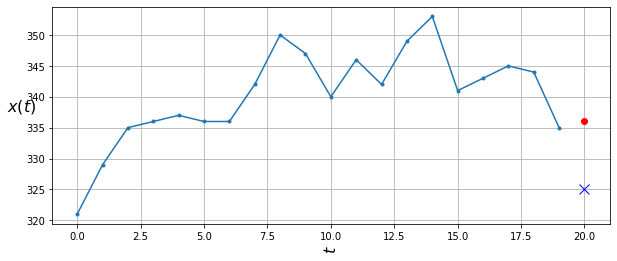

입력데이터 : [321. 329. 335. 336. 337. 336. 336. 342. 350. 347. 340. 346. 342. 349.
 353. 341. 343. 345. 344. 335.]
실제값 : 325.00
예측값 : 336.01
오차 : 11.01
오차율 : 3.39%


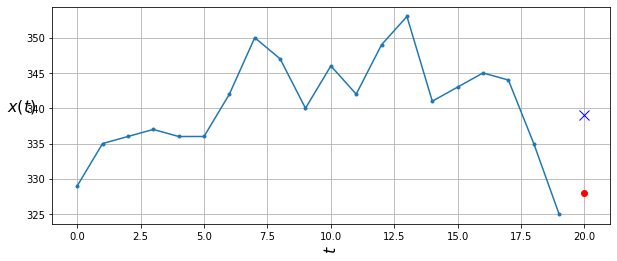

입력데이터 : [329. 335. 336. 337. 336. 336. 342. 350. 347. 340. 346. 342. 349. 353.
 341. 343. 345. 344. 335. 325.]
실제값 : 339.00
예측값 : 328.03
오차 : 10.97
오차율 : 3.23%


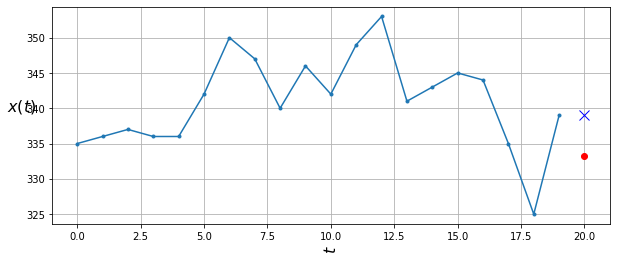

입력데이터 : [335. 336. 337. 336. 336. 342. 350. 347. 340. 346. 342. 349. 353. 341.
 343. 345. 344. 335. 325. 339.]
실제값 : 339.00
예측값 : 333.29
오차 : 5.71
오차율 : 1.68%


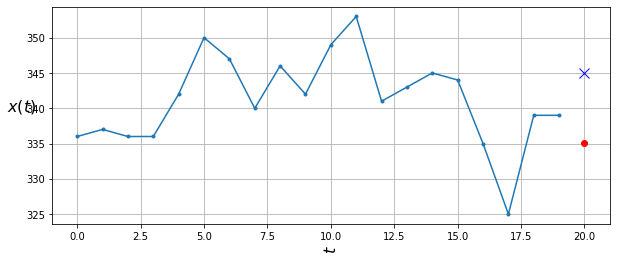

입력데이터 : [336. 337. 336. 336. 342. 350. 347. 340. 346. 342. 349. 353. 341. 343.
 345. 344. 335. 325. 339. 339.]
실제값 : 345.00
예측값 : 335.14
오차 : 9.86
오차율 : 2.86%


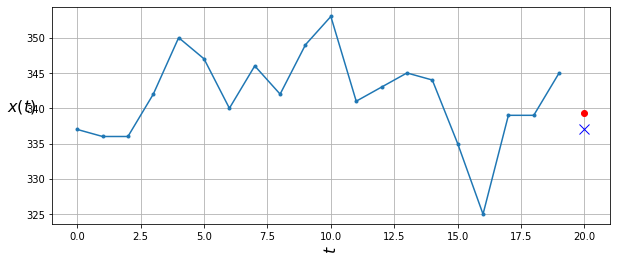

입력데이터 : [337. 336. 336. 342. 350. 347. 340. 346. 342. 349. 353. 341. 343. 345.
 344. 335. 325. 339. 339. 345.]
실제값 : 337.00
예측값 : 339.35
오차 : 2.35
오차율 : 0.70%


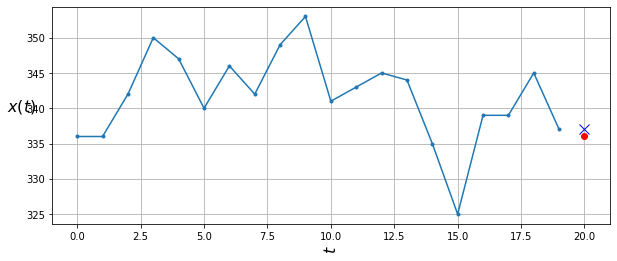

입력데이터 : [336. 336. 342. 350. 347. 340. 346. 342. 349. 353. 341. 343. 345. 344.
 335. 325. 339. 339. 345. 337.]
실제값 : 337.00
예측값 : 336.08
오차 : 0.92
오차율 : 0.27%


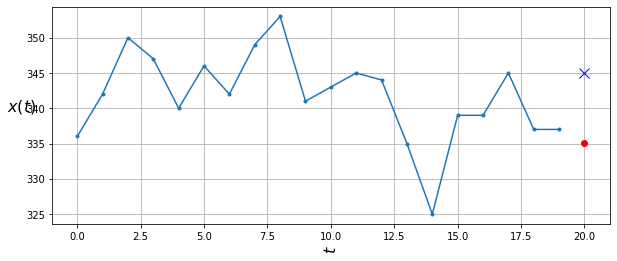

입력데이터 : [336. 342. 350. 347. 340. 346. 342. 349. 353. 341. 343. 345. 344. 335.
 325. 339. 339. 345. 337. 337.]
실제값 : 345.00
예측값 : 335.03
오차 : 9.97
오차율 : 2.89%


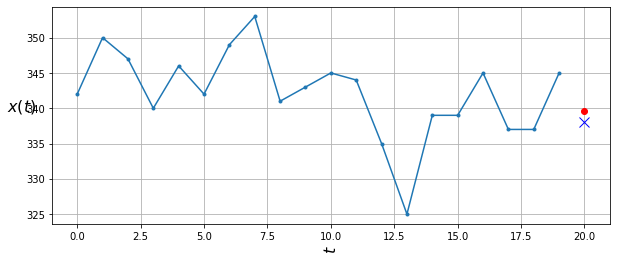

입력데이터 : [342. 350. 347. 340. 346. 342. 349. 353. 341. 343. 345. 344. 335. 325.
 339. 339. 345. 337. 337. 345.]
실제값 : 338.00
예측값 : 339.55
오차 : 1.55
오차율 : 0.46%


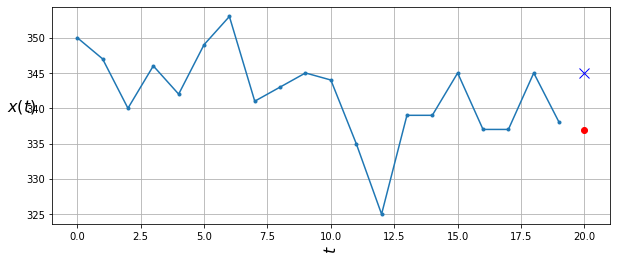

입력데이터 : [350. 347. 340. 346. 342. 349. 353. 341. 343. 345. 344. 335. 325. 339.
 339. 345. 337. 337. 345. 338.]
실제값 : 345.00
예측값 : 336.97
오차 : 8.03
오차율 : 2.33%


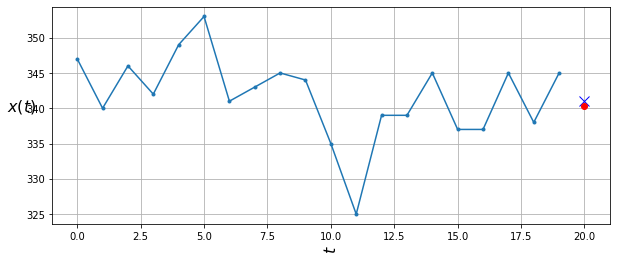

입력데이터 : [347. 340. 346. 342. 349. 353. 341. 343. 345. 344. 335. 325. 339. 339.
 345. 337. 337. 345. 338. 345.]
실제값 : 341.00
예측값 : 340.30
오차 : 0.70
오차율 : 0.21%


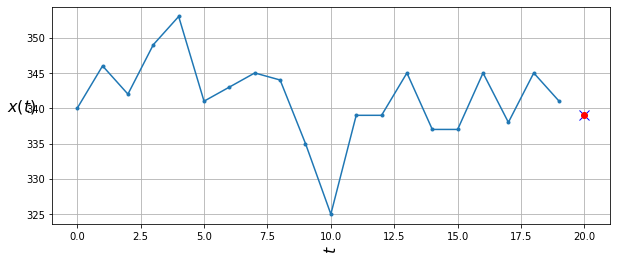

입력데이터 : [340. 346. 342. 349. 353. 341. 343. 345. 344. 335. 325. 339. 339. 345.
 337. 337. 345. 338. 345. 341.]
실제값 : 339.00
예측값 : 339.05
오차 : 0.05
오차율 : 0.02%


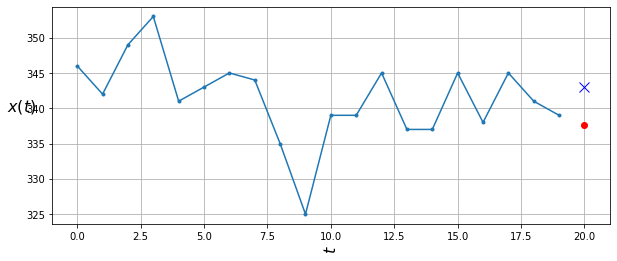

입력데이터 : [346. 342. 349. 353. 341. 343. 345. 344. 335. 325. 339. 339. 345. 337.
 337. 345. 338. 345. 341. 339.]
실제값 : 343.00
예측값 : 337.63
오차 : 5.37
오차율 : 1.57%


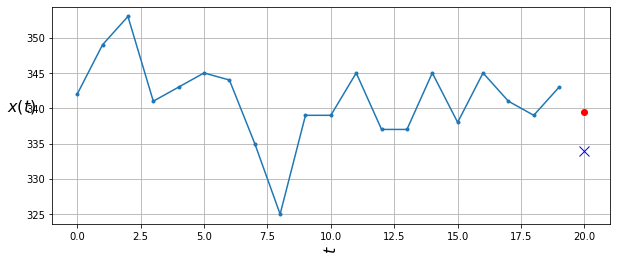

입력데이터 : [342. 349. 353. 341. 343. 345. 344. 335. 325. 339. 339. 345. 337. 337.
 345. 338. 345. 341. 339. 343.]
실제값 : 334.00
예측값 : 339.42
오차 : 5.42
오차율 : 1.62%


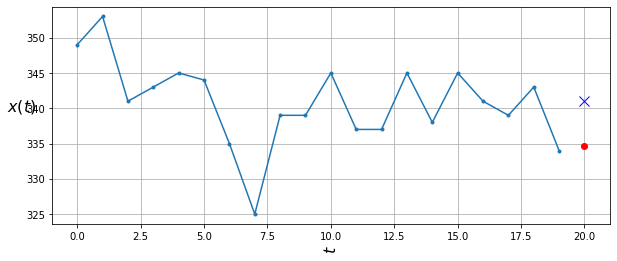

입력데이터 : [349. 353. 341. 343. 345. 344. 335. 325. 339. 339. 345. 337. 337. 345.
 338. 345. 341. 339. 343. 334.]
실제값 : 341.00
예측값 : 334.63
오차 : 6.37
오차율 : 1.87%


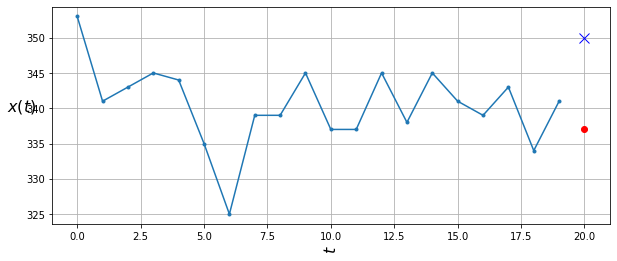

입력데이터 : [353. 341. 343. 345. 344. 335. 325. 339. 339. 345. 337. 337. 345. 338.
 345. 341. 339. 343. 334. 341.]
실제값 : 350.00
예측값 : 337.07
오차 : 12.93
오차율 : 3.69%


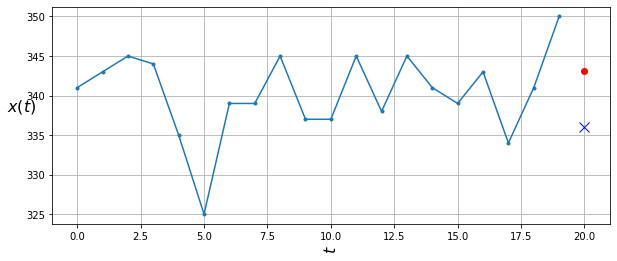

입력데이터 : [341. 343. 345. 344. 335. 325. 339. 339. 345. 337. 337. 345. 338. 345.
 341. 339. 343. 334. 341. 350.]
실제값 : 336.00
예측값 : 343.15
오차 : 7.15
오차율 : 2.13%


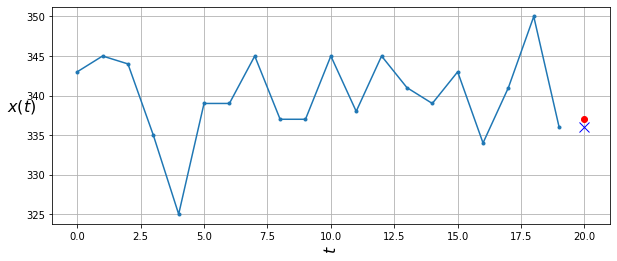

입력데이터 : [343. 345. 344. 335. 325. 339. 339. 345. 337. 337. 345. 338. 345. 341.
 339. 343. 334. 341. 350. 336.]
실제값 : 336.00
예측값 : 337.09
오차 : 1.09
오차율 : 0.32%


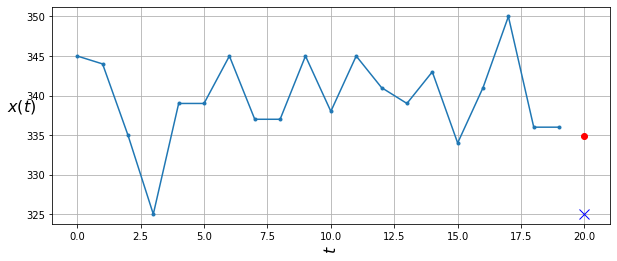

입력데이터 : [345. 344. 335. 325. 339. 339. 345. 337. 337. 345. 338. 345. 341. 339.
 343. 334. 341. 350. 336. 336.]
실제값 : 325.00
예측값 : 334.89
오차 : 9.89
오차율 : 3.04%


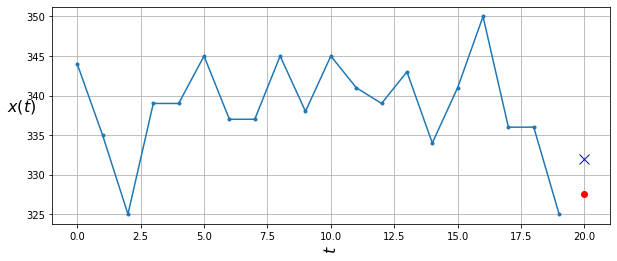

입력데이터 : [344. 335. 325. 339. 339. 345. 337. 337. 345. 338. 345. 341. 339. 343.
 334. 341. 350. 336. 336. 325.]
실제값 : 332.00
예측값 : 327.60
오차 : 4.40
오차율 : 1.32%


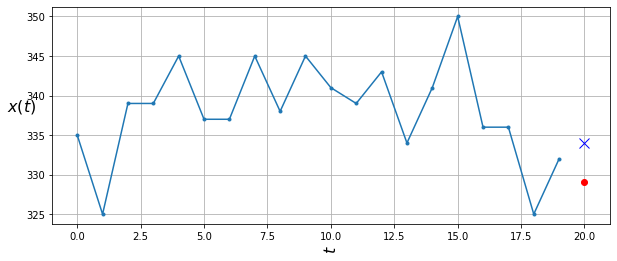

입력데이터 : [335. 325. 339. 339. 345. 337. 337. 345. 338. 345. 341. 339. 343. 334.
 341. 350. 336. 336. 325. 332.]
실제값 : 334.00
예측값 : 329.03
오차 : 4.97
오차율 : 1.49%


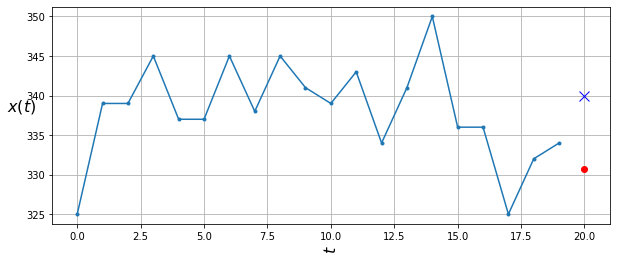

입력데이터 : [325. 339. 339. 345. 337. 337. 345. 338. 345. 341. 339. 343. 334. 341.
 350. 336. 336. 325. 332. 334.]
실제값 : 340.00
예측값 : 330.67
오차 : 9.33
오차율 : 2.74%


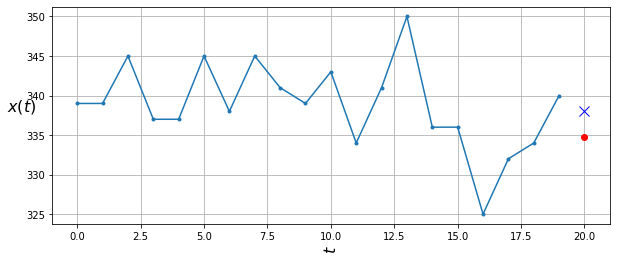

입력데이터 : [339. 339. 345. 337. 337. 345. 338. 345. 341. 339. 343. 334. 341. 350.
 336. 336. 325. 332. 334. 340.]
실제값 : 338.00
예측값 : 334.77
오차 : 3.23
오차율 : 0.96%


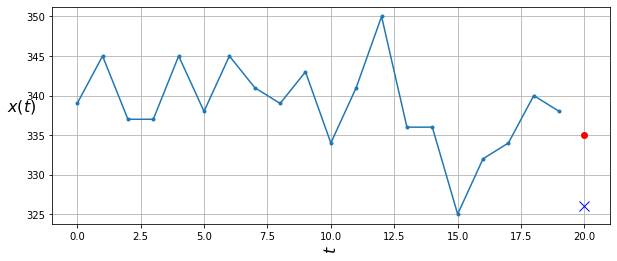

입력데이터 : [339. 345. 337. 337. 345. 338. 345. 341. 339. 343. 334. 341. 350. 336.
 336. 325. 332. 334. 340. 338.]
실제값 : 326.00
예측값 : 335.06
오차 : 9.06
오차율 : 2.78%


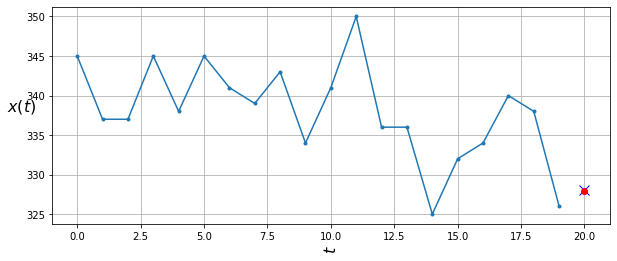

입력데이터 : [345. 337. 337. 345. 338. 345. 341. 339. 343. 334. 341. 350. 336. 336.
 325. 332. 334. 340. 338. 326.]
실제값 : 328.00
예측값 : 327.93
오차 : 0.07
오차율 : 0.02%


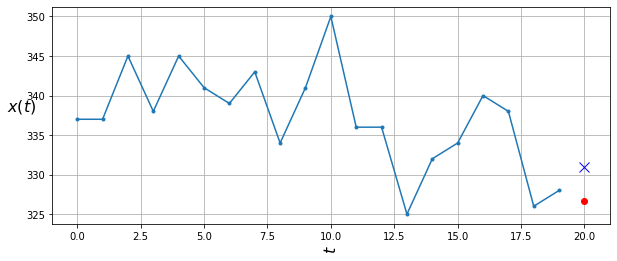

입력데이터 : [337. 337. 345. 338. 345. 341. 339. 343. 334. 341. 350. 336. 336. 325.
 332. 334. 340. 338. 326. 328.]
실제값 : 331.00
예측값 : 326.70
오차 : 4.30
오차율 : 1.30%


In [39]:
for TIME_STEP in range(1000,1110):
    p_usage_hist = scaler.inverse_transform(X_test[TIME_STEP])
    p_usage_hist = p_usage_hist[:, 0]

    p_usage_real  = dataset[TIME_STEP + HISTORY_DATA_SIZE][0]

    pred = model.predict(
        X_test[TIME_STEP].reshape(1, HISTORY_DATA_SIZE, -1))
    pred = pred[0][0]
    p_usage_pred = scaler.inverse_transform([[pred, 0, 0]])[0][0]

    error = abs(p_usage_pred - p_usage_real)
    error_rate = error/p_usage_real*100

    fig, axes = plt.subplots(nrows=1, ncols=1, 
                             sharey=True, figsize=(10, 4))
    plot_series(p_usage_hist, p_usage_real, p_usage_pred)
    plt.show()

    print(f'입력데이터 : {p_usage_hist}')
    print(f'실제값 : {p_usage_real:.2f}')
    print(f'예측값 : {p_usage_pred:.2f}')
    print(f'오차 : {error:.2f}')
    print(f'오차율 : {error_rate:.2f}%')